In [1]:
# Importation de quelques librairies supplémentaires
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from pandas_profiling import ProfileReport
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import plot_roc_curve, f1_score, recall_score
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV, GridSearchCV
%matplotlib inline

In [2]:
# Style des graphiques seaborn
sns.set_theme(style = "whitegrid")

In [3]:
data_stroke = pd.read_csv("stroke_prediction/donnees/healthcare-dataset-stroke-data.csv")

In [4]:
data_frame = data_stroke.copy()

# DEMARCHE DE TRAVAIL
## OBJECTIF MESURABLE
**OBJECTIF** :
Prédire si une personne est atteinte d'un accident vasculaire cérébral ou pas à partir des données personnelles et cliniques fournies (problème de classification). Il est essentiel de noter qu'il est plus urgent, dans ce cas de figure, de détecter toutes les personnes malades (et non celles qui sont vraiment malades parmi ceux qui sont identifiés comme malade). Sinon un patient malade peut être diagnostiqué comme sain alors que ce n'est pas le cas. Nous préférerions ainsi la sensibilité à la précision.

**METRIQUE ET SCORE A ATTEINDRE** : La proportion de la classe positive est largement inférieure à la proportion de la classe négative (nous notons une forte déséquilibre de classes). Dans ce cas de figure, la métrique accuracy ne sera pas assez performante pour évaluer notre modèle de classification. A la place, nous allons utiliser les métriques sensibilité et précision pour valider notre modèle :

- **Sensibilité** : $\frac{VP}{VP+FN}$. Elle permet de calculer le pourcentage de tests positifs parmi les patients réellement atteints d'AVC ;
- **Spécificité** : $\frac{VN}{VN+FP}$. Elle permet de calculer le pourcentage de tests négatifs parmi les patients réellement sains. C'est la sensibilité pour les test négatifs ;
- **Précision** : $\frac{VP}{VP+FP}$. Elle permet de calculer le pourcentage de patients réellement malades parmi ceux dont le test est positif ;
- **F1-score** : $\frac{2\times Sensibilite \times Precision}{Sensibilite+Precision}$ ;
- Avec :
        
    - $VP$ : Nombre de Vrais Positifs ;
    - $VN$ : Nombre de Vrais Négatifs ;
    - $FN$ : Nombre de Faux Négatifs ;
    - $FP$ : Nombre de Faux Positifs ;
        
Nous nous fixons une sensibilité supérieure à **80%**. Nous pouvons également utiliser des outils supplémentaires comme **les courbes ROC et Precision-Recall** pour affiner nos choix de performance. Nous pouvons nous fixer une aire sous la courbe (AUC) supérieure ou égale à **80%**.

## EXPLORATION DES DONNEES

### ANALYSE DE LA FORME

**CIBLE** : La variable dépendante est la variable **stroke** qui contient des données de type discrète. Cette variable indique si une personne est atteinte d'un accident vasculaire cérébral (1 pour atteinte) ou pas (0 pour non atteinte). Nous allons abréger, par la suite, le terme *accident vasculaire cérébral* par *AVC* pour faciliter l'écrit. Nous devons transformer, plus tard, la variable cible en variable catégorielle non ordinale (cela nous permettra de différencier la catégorie "être atteint(e) d'AVC" de la catégorie "être non atteint(e) d'AVC"). Nous devrons ainsi utiliser un modèle de classification (classification model) pour déterminer si un patient est malade ou sain.

**NOMBRE DE LIGNES ET DE COLONNES** : Nous avons identifié 5110 observations et 12 variables (dont la cible). Le nombre d'observations est inférieur à 10000, donc notre dataset ne contient pas énormément d'observations mais assez pour entraîner un modèle.

**TYPES DE VARIABLES** : Parmi les variables explicatives, nous avons identifié 7 variables catégorielles (dont deux contiennent des valeurs discrètes et les autres contiennent des valeurs de type chaîne de caractères) et 3 variables non catégorielles.

- Les variables de type object ont pour valeurs possibles les suivantes :

    - **gender** (genre) : contient les valeurs *Male* (Homme), *Female* (Femelle) ou *Other* (ni Homme, ni Femme) ;
    - **ever_married** (jamais marié(e)) : peut prendre les valeurs *Yes* (Oui) ou *No* (Non) ;
    - **work_type** (type de travail) : peut prendre les valeurs *Private* (Privée), *Self_employed* (Auto emploi ou Travail autonome), *Govt_job* (Travail au gouvernement), *children* (enfant), *Never_worked* (N'a jamais travaillé(e)) ;
    - **Residence_type** (type de résidence) : peut prendre les valeurs *Urban* (Urbaine), *Rural* (Rurale) ;
    - **smoking_status** (statut de fumeur) : contient les valeurs *formerly_smoked* (a fumé(e) dans le passé), *never_smoke* (n'a jamais fumé), *smokes* (fume), *Unknow* (donnée non recueillie).


- Quant aux variables catégorielles **hypertension** et **heart_disease** (maladie de coeur), elles peuvent prendre les valeurs 1 (pour *positive*) ou 0 (pour *négative*). 
- Nous identifions une variable discrète non categorielle (**age**) dont les valeurs varient de 0.08 (enfant de 9 mois) à 82 (adulte de 82 ans). Sa valeur moyenne est de 43 (adulte de 43 ans).
- Le dataset ne contient que deux variables continues, **avg_glucose_level** (niveau moyen de glucose dans le sang) et **bmi** (indice de masse corporelle). Ces deux variables ne s'expriment pas avec les mêmes unités :

    - La variable avg_glucose_level a pour valeur maximale 271.74 et pour valeur minimale 55.12. Sa valeur moyenne est de 106.15.
    - La variable bmi a pour valeur maximale 97.60 et pour valeur minimale 10.30. Sa valeur moyenne est 28.89.


- Nous définirons plus en détail ces variables dans la partie analyse du fond.

**IDENTIFICATION DES VALEURS MANQUANTES** : Nous remarquons que seule la variable bmi contient des valeurs manquantes qui sont un peu dispersées dans le dataset. Mais en sachant que les valeurs manquantes ne représentent que 16% de l'ensemble des données présentes dans la colonne bmi et que nous allons choisir un échantillon aléatoire pour l'entraînement du modèle (ainsi que pour l'évaluation) donc on peut supposer que le remplacement des valeurs manquantes par la valeur la plus fréquente de la variable bmi constitue une bonne stratégie.

**IDENTIFICATION DES VALEURS REDONDANTES** : Les données ne contiennent pas d'observations dupliquées.

### ANALYSE DU FOND
**VISUALISATION DE LA CIBLE** : Nous remarquons que 95.13% des patients sont atteintes d'AVC contre seulement 4.87% des patients atteintes d'AVC. La proportion de patients non malades est largement supérieure au nombre de patients non malades.

**COMPREHENSION DES DIFFERENTES VARIABLES** : 

- **id** : La variable id contient des valeurs discrètes et identifie chaque observation de manière unique. Elle n'apporte aucune information supplémentaire et donc n'influence pas le fait qu'une personne soit malade ou non. La variable id doit être supprimée.
- Variables catégorielles :

    - **Hypertension** : Cette variable indique si oui ou non, le patient souffre d'hypertension. Un patient est testé positif à l'hypertension si on constate à deux reprises, et pas dans le même jour, une tension systolique supérieure ou égale à 140 mm Hg et/ou une tension diastolique supérieure ou égale à 90 mm Hg. Selon les tests cliniques, une hypertension peut souvent être la cause d'AVC. Nous verrons par la suite si les données recueillies de cette variable sont fiables. La colonne hypertension contient 90% de tests négatifs et 10% de tests positifs.
    - **heart_disease** : La variable heart_disease indique si le patient est atteint de cardiopathie (maladie cardiaque) ou pas. Il y a différents types de cardiopathies et nous verrons si ces derniers peuvent influencer le risque d'attraper un AVC. La colonne heart_disease contient 95% de tests positifs contre seulement 5% de tests négatifs. Cependant, nous savons que l'hypertension non traitée peut causer la cardiopathie. Donc on peut supposer, d'ores et déjà, que ces deux variables sont fortement corrélées (hypothèse à vérifier).
    - **gender** : La variable gender indique à quel sexe appartient le patient. On doit vérifier si le sexe du patient peut influencer le risque qu'il soit atteint d'AVC. La colonne gender est composée de 58% de femmes, de 41% d'hommes et très peu (presque 0%) de sexe de type autre.
    - **ever_married** : Cette variable indique si le patient a déjà été marié. L'analyse de cette variable doit nous permettre de dire si le patient a plus de chance d'attraper un AVC en s'étant déjà marié (dans le temps présent ou passé) ou pas. Nous notons 66% des patients qui se sont jamais mariés et 34% qui se sont déjà mariés. 
    - **work_type** : Elle indique le type de travail effectué par un patient. On identifie 57% de patients travaillant dans le secteur privé (professions et secteurs d'activité ne dépendant pas de l'Etat), 16% des patients effectuant du travail autonome (ils sont leurs propres employés), 13% des patients sont des enfants (on n'a pas plus d'informations sur la catégorie children mais on suppose pour l'instant que le patient est un enfant et donc qu'il n'a pas besoin de travailler), presque 13% des patients travaillent pour le gouvernement (dans le secteur public) et seulement 0.4% n'ont jamais travaillé. Pour les patients dont le type de travail est children, nous devons vérifier si leurs âges indiquent que ce sont des enfants ou pas (c'est-à-dire certains sont des adultes).
    - **residence_type** : Cette variable indique le type de résidence du patient. 51% des patients résident dans un milieu urbain (ville) et 49% des patients résident dans un milieu rural (campagne). Les proportions de ces deux classes sont presque similaires.
    - **smoking_status** : Elle indique si le patient est/était un fumeur ou pas. 37% des patients n'ont jamais fumé, 30% des patients n'indiquent pas s'ils fument, 17% des patients ont fumé auparavant et 15% des patients disent fumer au moment où on les interrogeait. La catégorie unknow (inconnue) peut constituer un problème car elle n'apporte aucune information utile. Nous vérifierons par la suite si cette variable apporte de l'information à notre modèle.


- Variables non catégorielles :

    - **age** : Nous constatons que les patients qui sont âgés entre 37 et 63 ans sont plus nombreux dans la base de données, suivis des patients qui sont âgés entre 78 et 82 ans tandis que les plus jeunes sont les moins nombreux.
    - **avg_glucose_level** : Le niveau moyen de glucose dans le sang indique si, oui ou non, le patient est atteint de diabète. Cette variable s'exprime en mg/dL (milligrammes par décilitre). Les patients qui souffrent de diabète ont un niveau moyen de glucose supérieur ou égale à 200 mg/dL. Par contre, un niveau moyen de glucose, inférieur à 140 mg/dL, est considéré comme normal. Nous constatons que la plupart des patients n'ont pas de diabète car une grande partie des patients ont un niveau moyen de glucose tournant autour de 75-87 mg/dL de sang. Nous remarquons qu'environ 10 à 20% des patients ont un niveau moyen de glucose tournant autour de 210-225 mg/dL. On peut considérer que ces derniers sont atteints de diabète.
    - **bmi** : L'indice de masse corporelle (IMC) permet d'indiquer la corpulence d'un patient. Il s'exprime en kg/m2 (kilogrammes par mètre carré). Une personne est considérée comme obèse si son IMC dépasse 30 kg/m2. La plupart des patients examinés ont un IMC situé autour de 29 kg/m2. Ces derniers présentent un cas de surpoids ou d'obésité modérée (dont les IMC sont respectivement situés entre 25 et 30 kg/m2 et entre 30 et 35 kg/m2).
    
**VISUALISATION DES RELATIONS ENTRE LES VARIABLES EXPLICATIVES ET LA CIBLE** :

- Relations Cible - variables catégorielles :

    - Pour la variable work_type : Nous remarquons que les patients qui ont pour type de travail children ont plus de chance de ne pas attraper d'AVC que les patients qui effectuent d'autres types de travail. On a peu de patients non travailleurs dans la variable work_type donc on ne peut rien dire par rapport à cette catégorie (mais il est possible qu'elle influence aussi le fait qu'on soit atteint d'AVC ou pas).
    - Pour la variable smoking_type : Nous remarquons que les patients ne disant pas s'ils fument/fumaient présentent une proportion de malades inconsistante par rapport aux autres types de fumeurs. Cela est dû au fait que la catégorie unknow n'est pas fiable (elle se comporte comme une valeur manquante).


- Relations Cible - Variables non catégorielles :

    - Parmi les variables non catégorielles, seule la variable âge influence le fait qu'un patient soit atteint d'AVC ou pas. Il y a plus de risque d'attraper un AVC chez les patients plus âgés ;
    - Pour les deux autres variables restantes nous constatons que les distributions sont presque les mêmes pour les patients malades et non malades ;
    - Nous vérifierons plus amplement ces hypothèses à travers un test de student.
        
    


**VISUALISATION DES RELATIONS ENTRE VARIABLES QUANTITATIVES** : 

Les variables quantitatives ne partagent aucune forte corrélation entre elles.

**VISUALISATION DES RELATIONS ENTRE VARIABLES CATEGORIELLES ET QUANTITATIVES** : 

Nous constatons que quelques variables catégorielles ont de fortes corrélations avec des variables quantitatives.

- La variable **age** est fortement corrélée avec les variables **work_type**, **smoking_status** et **ever_married**. Pour sa relation avec les autres variables catégorielles nous remarquons de légères corrélations ou quasiment pas de corrélations pour certaines.
- La variable **bmi** est, pour son cas, fortement corrélée avec les variables **ever_married** et **work_type**.
- En revenant au niveau de pandas profiling, nous constatons que nos analyses sont soutenues par les remarques faites par la librairie (aucune incohérence n'est à noter).


**IDENTIFICATION DES VALEURS ABERRANTES** : 

Nous constatons que quelques valeurs dépassent la limite et peuvent être considérées comme aberrantes pour le moment.

- La variable age ne comporte presque pas de valeurs aberrantes.
- Les variables bmi et avg_glucose_level contiennent par contre des valeurs aberrantes.
- La variable avg_glucose_level ne contient des valeurs aberrantes que du côté de la classe *test negatif* de la variable stroke alors que la variable bmi en comporte pour les deux classes (mais beaucoup plus du côté de la classe *test negatif*). 
- Cependant pour la variable avg_glucose_level nous constatons que ces valeurs coïncident avec les valeurs désignant le groupe de patients atteints de diabète. Donc nous devrons traiter ces valeurs avec précaution car elles peuvent être utiles à l'identification de patients atteints d'AVC.


**PREMIERE CONCLUSION** :

- On note une forte désiquilibre de classes au niveau de la cible. Le pourcentage de patients non atteints dépasse les **90%**. Ce problème peut-être traité avec l'équilibrage des classes à l'aide de quelques techniques de rééchantillonnage (sous échantillonnage, sur échantillonnage ou les deux).
- On constate une dépendance entre la variable cible et la variable age.
- La variable id ne comporte aucune information utile donc il est préférable de la supprimer de la base de données.
- La base de données contient des valeurs manquantes que nous allons remplacer par la valeur la plus fréquente de la variable bmi ;
- La catégorie unknow de la variable smoking_status n'apporte aucune information supplémentaire donc nous devons la remplacer par une catégorie plus intéressante (*never smoked* par exemple) ;
- Les variables quantitatives ne sont pas corrélées entre elles ;
- La variable age est fortement corrélée avec certaines variables catégorielles. Notamment les variables work_type, ever_married et smoking_status ;
- La variable bmi est aussi fortement corrélée avec les variables catégorielles ever_married et work_type ;
- Nous devons garder les variables age et bmi et supprimer les variables smoking_status, work_type et ever_married ;
- Des tests supplémentaires seront réalisé pour étayer certaines hypothèses ou les rejeter ;
- Les variables quantitatives comportent des valeurs 'anormales'. Nous allons vérifier s'il est nécessaire de les remplacer ou de les supprimer. Ces données peuvent être utiles car ils caractérisent un groupe de patients.
- Nous allons retenir pour l'instant les variables hypertension et heart_disease qui sont cliniquement très intéressantes pour nos analyses.


**TESTS D'HYPOTHESES** : Ces tests nous permettrons de valider ou de rejeter certaines hypothèses.

- Testons si les variables quantitatives influencent le fait qu'un patient soit atteint d'AVC ou pas (nous noterons H0 l'hypothèse selon laquelle une variable n'a pas d'influence sur la cible) :

    - Le test de student nous indique que les variables **age** et **avg_glucose_level influencent le fait qu'un patient soit atteint d'AVC ou pas**.
     
    - La variable **bmi n'entretient pas de dépendance avec la variable stroke**.




**SECONDE CONCLUSION** :

- Les variables **age** et **avg_glucose_level** apportent de l'information contrairement à la variable bmi qui, elle, peut-être supprimée.
- Les variables à supprimer sont donc : **bmi**, **work_type**, **ever_married**, **smoking_status**, **id**. Pour le moment nous ne supprimerons que ces variables. Nous ferons une sélection antérieure de variables si on constate un sur entraînement du modèle.


# Exploration des données

## Identification de la cible

**Contenu des dix premières lignes.**

In [5]:
# Vérifions le contenu des dix premières lignes  
data_frame.head(10)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
6,53882,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
7,10434,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
9,60491,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1


<p style="font-family:'Times New Roman'">Nous savons que la cible est la variable stroke. C'est la variable à expliquer.</p>

**Type de la cible**

In [6]:
# Déterminons le type de la cible et son contenu
# Type de la variable
print("La cible a pour type : ",str(data_frame["stroke"].dtype))

La cible a pour type :  int64


**Valeurs possibles de la cible**

In [7]:
# Vérifions les valeurs possibles du target
print("La cible est composée des modalités : ", data_frame["stroke"].unique().tolist())

La cible est composée des modalités :  [1, 0]


## Nombre de ligne et de colonnes

In [8]:
# Forme du dataframe
print("Nous avons au total", data_frame.shape[0], " lignes et ", data_frame.shape[1], " colonnes dans le jeu de données.")

Nous avons au total 5110  lignes et  12  colonnes dans le jeu de données.


## Nombre de ligne et de colonnes

**Types des colonnes.**

In [9]:
# Identifions les types des variables
data_frame.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

Nous identifions 7 colonnes de type catégorielles.

In [10]:
categorical_columns = ["hypertension", "heart_disease"]
categorical_columns.extend(data_frame.select_dtypes('object').columns)

**Les modalités possibles des variables de type *chaîne de caractères***.

In [11]:
# Pour chaque variable de type object vérifions ses catégories
for column in data_frame.select_dtypes('object').columns:
    print(f"Valeurs uniques de {column:-<20} {data_frame[column].unique()}\n")

Valeurs uniques de gender-------------- ['Male' 'Female' 'Other']

Valeurs uniques de ever_married-------- ['Yes' 'No']

Valeurs uniques de work_type----------- ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']

Valeurs uniques de Residence_type------ ['Urban' 'Rural']

Valeurs uniques de smoking_status------ ['formerly smoked' 'never smoked' 'smokes' 'Unknown']



**Les modalités possibles des variables *hypertension* et *heart_disease***.

In [12]:
# Vérifions les valeurs que contient les variables hypertension et heart_disease
for column in categorical_columns[:2]:
    print(f"Modalités de la colonne {column:-<30} {data_frame[column].unique()}\n")

Modalités de la colonne hypertension------------------ [0 1]

Modalités de la colonne heart_disease----------------- [1 0]



In [13]:
non_categorical_columns = ["age", "avg_glucose_level", "bmi"]

**Description (résumé) des données quantitatives.**

In [14]:
# Vérifions les statistiques des colonnes non catégorielles
data_frame[non_categorical_columns].describe()

,age,avg_glucose_level,bmi
count,5110.000000,5110.000000,4909.000000
mean,43.226614,106.147677,28.893237
std,22.612647,45.283560,7.854067
min,0.080000,55.120000,10.300000
25%,25.000000,77.245000,23.500000
50%,45.000000,91.885000,28.100000
75%,61.000000,114.090000,33.100000
max,82.000000,271.740000,97.600000


## Identification des valeurs manquantes

**Première analyse des valeurs manquantes par sommation.**

In [15]:
data_frame.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [16]:
# Stockage du dataframe des données manquantes dans une variable
na_values = data_frame.isna()

**Deuxième analyse par visualisation (Visualisation de la répartition des valeurs manquantes dans le dataset).**

Text(0.5, 1.0, 'Graphique des valeurs manquantes')

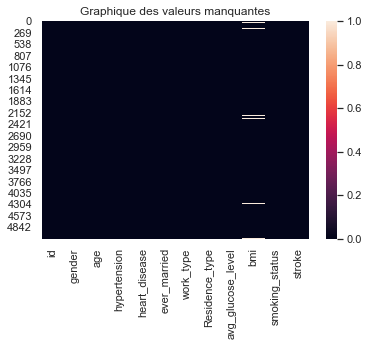

In [17]:
sns.heatmap(na_values)
plt.title("Graphique des valeurs manquantes")

Nous remarquons que seule la variable bmi contient des valeurs manquantes.

**pourcentage de valeurs manquantes dans la variable bmi.**

In [18]:
percentage_of_na = na_values["bmi"].sum()/data_frame.shape[1]

In [19]:
print(f"La variable bmi contient {percentage_of_na}% de valeurs manquantes.")

La variable bmi contient 16.75% de valeurs manquantes.


## Identification des observations redondantes

In [20]:
# Vérifions s'il y a des observations dupliquées dans le data
print("Le nombre d'observations redondantes est de ", data_frame.duplicated().sum())

Le nombre d'observations redondantes est de  0


Le dataset ne contient pas d'observations dupliquées.

## Visualisation de la cible

Nous devons voir la proportion de chaque classe au sein de la variable cible pour identifier si on a affaire à un désiquilibre de classes.

**Proportion de chaque classe.**

In [21]:
# Vérifions la proportion de chaque classe
proportions = data_frame["stroke"].value_counts(normalize = True)*100
proportions

0    95.127202
1     4.872798
Name: stroke, dtype: float64

**Diagramme en camembert de la proportion de chaque classe.**

Text(0, 0.5, '')

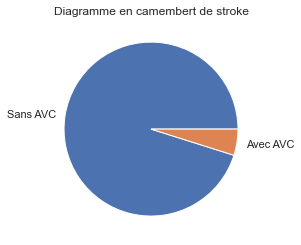

In [22]:
proportions.plot.pie(labels=["Sans AVC", "Avec AVC"])
plt.title("Diagramme en camembert de stroke")
plt.ylabel('')

Nous remarquons que 95.13% des patients sont atteints d'AVC contre seulement 4.87% de patients non atteints. Nous notons donc un fort désiquilibre de classes.

In [23]:
# Transformation en variable catégorielle de la cible
data_frame["stroke"] = data_frame["stroke"].astype("category")

## Compréhension des différentes variables

Analysons les variables à l'aide de graphiques.


In [24]:
# Transformation en type category de tous les variables catégorielles
for column in categorical_columns:
    data_frame[column] = data_frame[column].astype('category')

### Variables catégorielles

**Proportions des modalités pour chaque variable catégorielles (en pourcentages).**

In [25]:
# Récupérons les proportions des variables dans une liste
proportions = []
for column in categorical_columns:
    proportion = data_frame[column].value_counts(normalize = True)*100
    proportions.append(proportion)
    print(f"Colonne {column} :\n{proportion}\n-------------------\n")

Colonne hypertension :
0    90.254403
1     9.745597
Name: hypertension, dtype: float64
-------------------

Colonne heart_disease :
0    94.598826
1     5.401174
Name: heart_disease, dtype: float64
-------------------

Colonne gender :
Female    58.590998
Male      41.389432
Other      0.019569
Name: gender, dtype: float64
-------------------

Colonne ever_married :
Yes    65.616438
No     34.383562
Name: ever_married, dtype: float64
-------------------

Colonne work_type :
Private          57.240705
Self-employed    16.027397
children         13.444227
Govt_job         12.857143
Never_worked      0.430528
Name: work_type, dtype: float64
-------------------

Colonne Residence_type :
Urban    50.802348
Rural    49.197652
Name: Residence_type, dtype: float64
-------------------

Colonne smoking_status :
never smoked       37.025440
Unknown            30.215264
formerly smoked    17.318982
smokes             15.440313
Name: smoking_status, dtype: float64
-------------------



**Diagramme en barres des proportions pour chaque variable.**

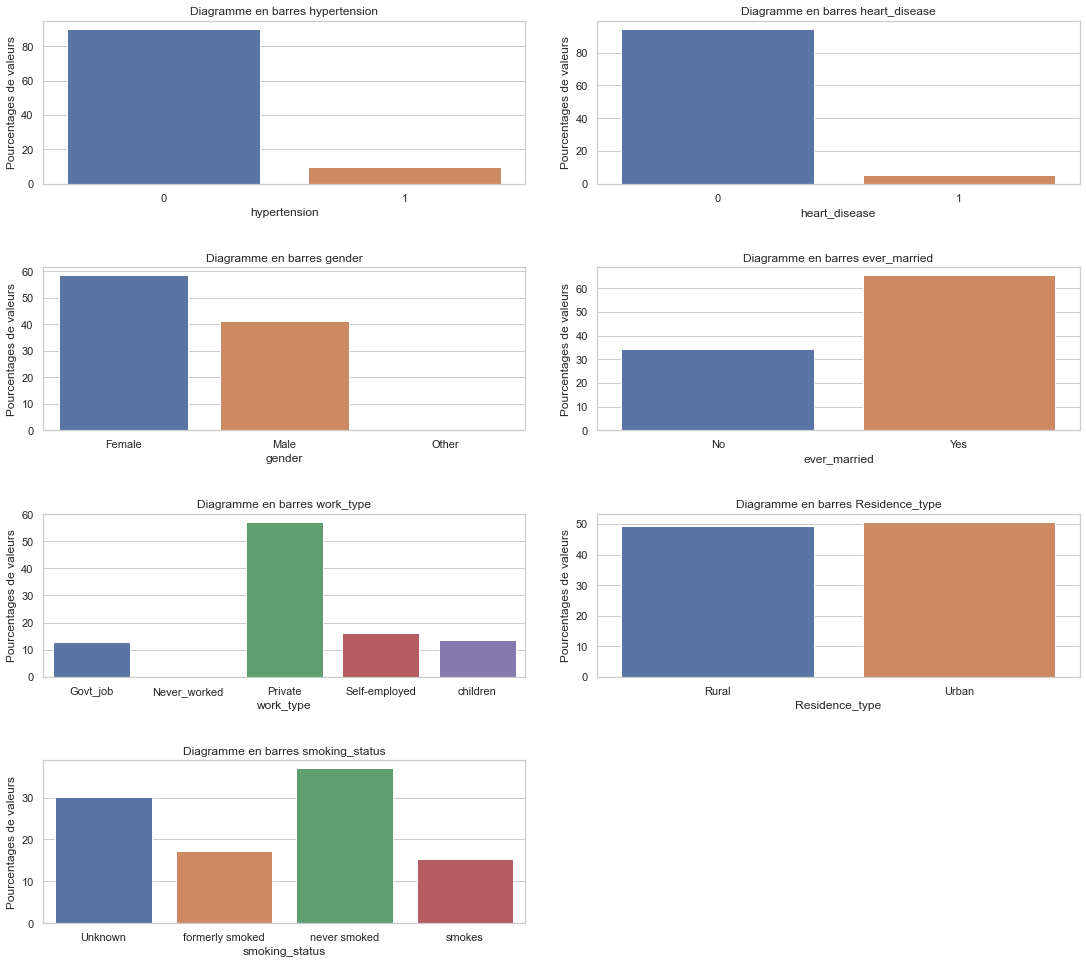

In [26]:
# Tracons le diagramme en barres des proportions pour chaque variable
fig, axs = plt.subplots(4, 2, figsize = (16, 14))
axs = axs.flat

for i, p in enumerate(proportions):
    fig.tight_layout(pad = 3)
    sns.barplot(x = p.index, y = p.values, ax = axs[i])
    axs[i].set_title(f"Diagramme en barres {p.name}")
    axs[i].set_xlabel(p.name)
    axs[i].set_ylabel("Pourcentages de valeurs")
    
fig.delaxes(axs[7])
    

### Variables non catégorielles

**Diagramme du nombre de patients en fonction de l'âge.**

Text(0.5, 1.0, 'Nombre de patients par age')

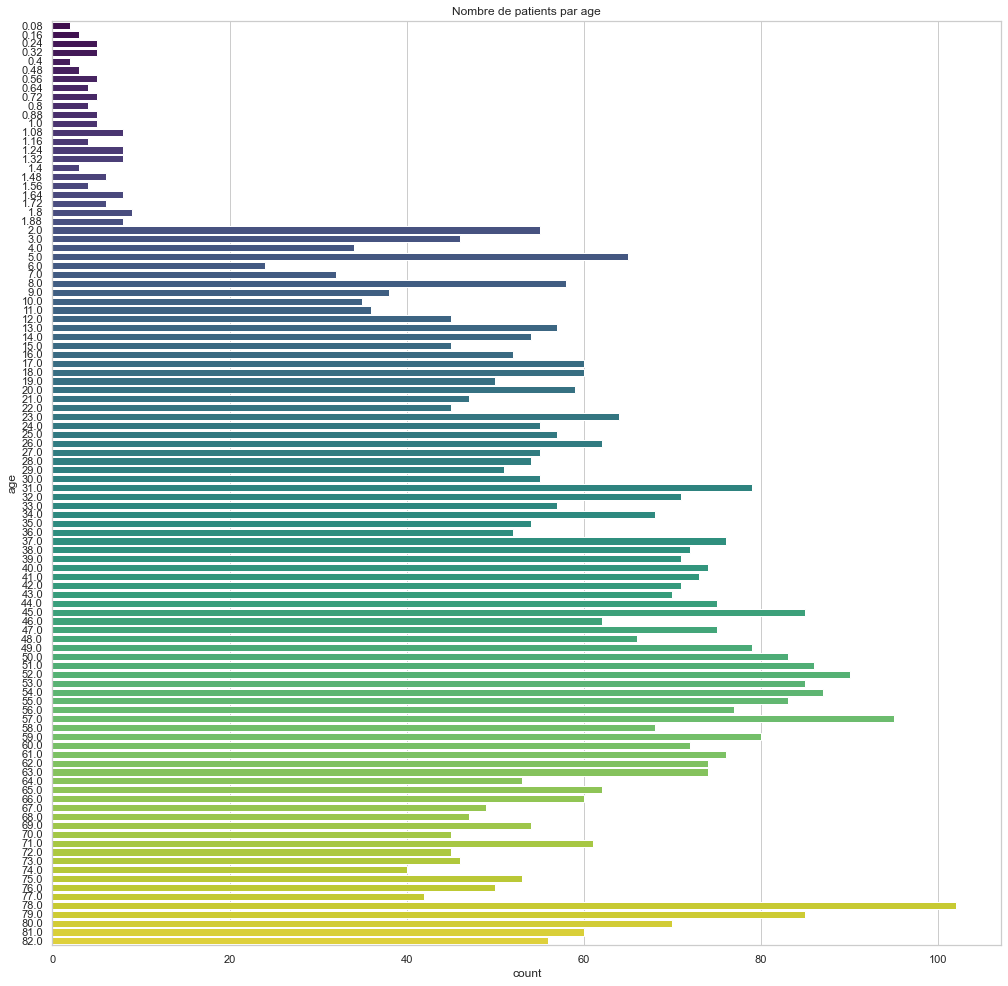

In [27]:
plt.figure(figsize = (17, 17))
sns.countplot(data = data_frame, y = "age", palette = "viridis")
plt.title("Nombre de patients par age")

Nous constatons qu'il y a plus de patients adultes que de patients jeunes. Le plus grand nombre de tests a été effectué sur les personnes agées de 78 ans. 

**Distribution des âges.**

Text(0.5, 1.0, 'Distribution de la variable age')

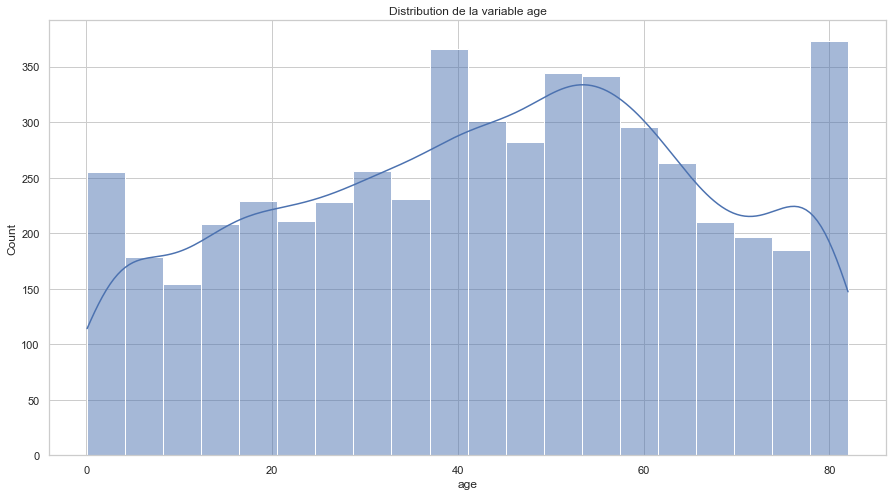

In [28]:
plt.figure(figsize = (15, 8))
sns.histplot(data = data_frame, x = "age", kde = True)
plt.title("Distribution de la variable age")

La variable age ne suit pas une distribution normale. Nous remarquons que la distribution est plus élevée au niveau des patients âgés entre 37 et 63 ans. Elle est moins élevée au niveau des jeunes patients.


**histogrammes du *niveau moyen de glucoses dans le sang* (avg_glucose_level) et de l'*indice de masse corporelle*(bmi).**

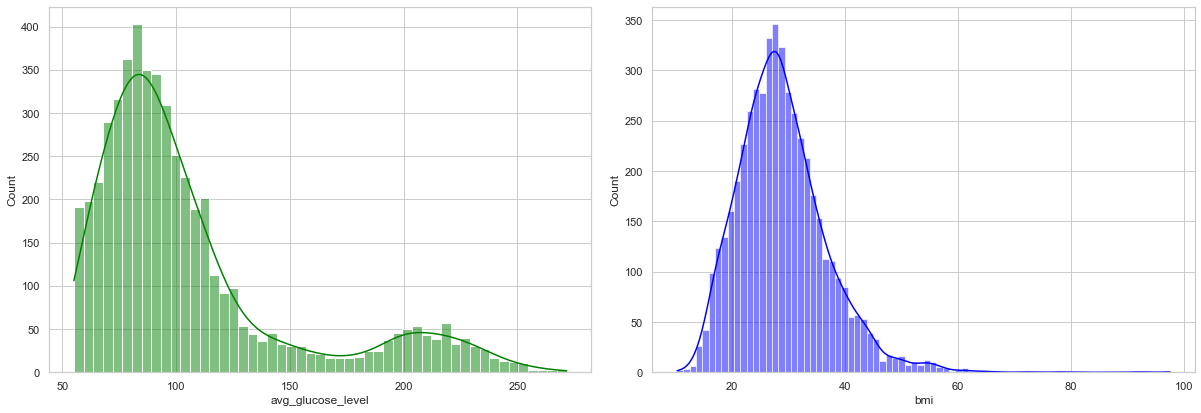

In [29]:
fig, axs = plt.subplots(1, 2, figsize = (17, 6))

axs = axs.flat

for i, column in enumerate(non_categorical_columns[-2:]):
    fig.tight_layout(w_pad = 3, pad = 1.2)
    color = "green" if i == 0 else "blue" 
    sns.histplot(data = data_frame, x = column, kde = True, ax = axs[i], color = color)
    

Nous remarquons, pour la variable avg_glucose_level, une composition de deux distributions (la deuxième à l'aire de se détacher de la première). La première distribution ressemble à une distribution normale avec une plus grande variance que la deuxième et sa moyenne tourne autour de 75-87 mg/dL de sang. Pour la deuxième distribution, dont la variance est plus faible, nous notons une moyenne tournant autour de 210-225 mg/dL.

Nous remarquons, pour la variable bmi, une distribution qui semble être normale avec une moyenne tournant autour de 30 kg/m2.

## Relations entre la cible et les variables explicatives

### Variables catégorielles / cible

**Analysons ces relations en utilisant les tableaux de contingence entre la cible et chaque variable catégorielle.**

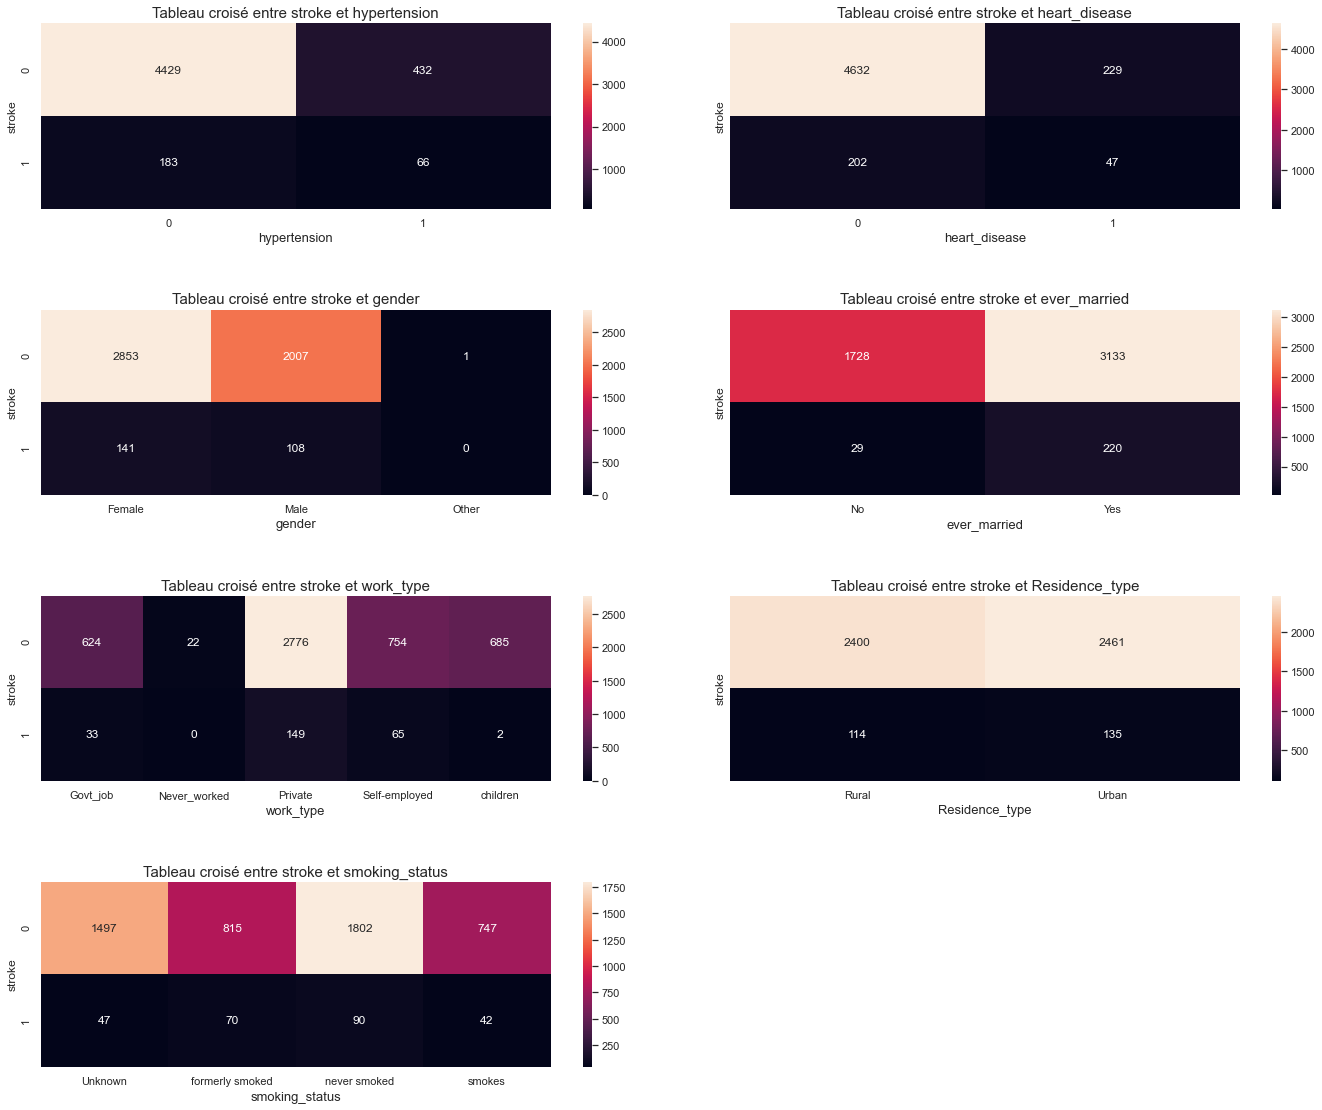

In [30]:
# Affichons des tableaux croisés entre la cible et chaque variable catégorielle à l'aide d'un heatmap.

fig, axs = plt.subplots(4, 2, figsize = (20, 16), sharey = True)
axs = axs.flat

for i, column in enumerate(categorical_columns):
    fig.tight_layout(pad = 3, h_pad = 4)
    sns.heatmap(pd.crosstab(data_frame["stroke"], data_frame[column]), annot = True, fmt = "d", ax = axs[i])
    axs[i].set_title(f"Tableau croisé entre stroke et {column}", fontsize = 15)
    axs[i].set_xlabel(column, fontsize = 13)
    
fig.delaxes(axs[7])

Nous remarquons que pour la variable work_type, on a une proportion de patients malades moins importante au niveau de la catégorie children.
Nous remarquons également que pour la variable smoking_status, la proportion de patients malades est moins importante au niveau de la catégorie unknown. Pour le reste des variables nous ne notons pas de différences considérables entre les différentes proportions.

### Variables non catégorielles / variable cible

Dans cette partie, nous devons affiner les analyses effectuées sur les variables non catégorielles en traçant des distributions suivant les différentes classes possibles de la variable cible. Nous vérifierons ensuite si les distributions obtenues sont semblables.

**Pour la variable age**

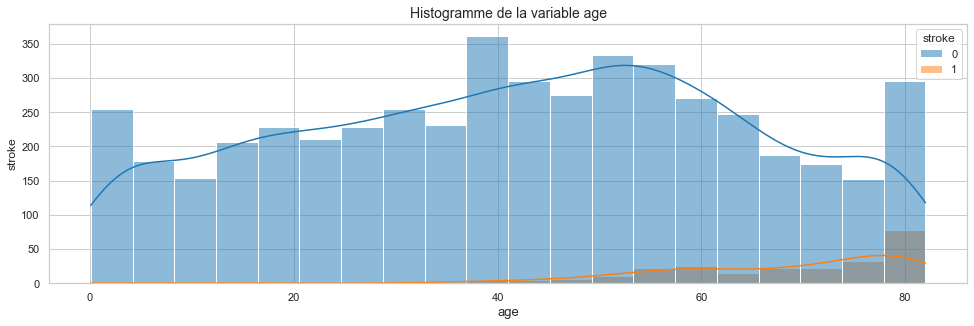

In [31]:
plt.figure(figsize = (15, 6))
sns.histplot(data = data_frame, x = "age", hue = "stroke", kde = True, palette = "tab10")
plt.title(f"Histogramme de la variable age", fontsize = 14)
plt.xlabel("age", fontsize = 13)
plt.ylabel("stroke", fontsize = 12)
plt.tight_layout(pad = 5)

<p style="font-family:'Times New Roman'">Nous voyons que les deux distributions sont différentes. Nous constatons que les personnes plus agées ont plus de risque d'être atteintes d'AVC.</p>

<p style="font-family:'Times New Roman'"><strong>Pour la variable avg_glucose_level</strong></p>

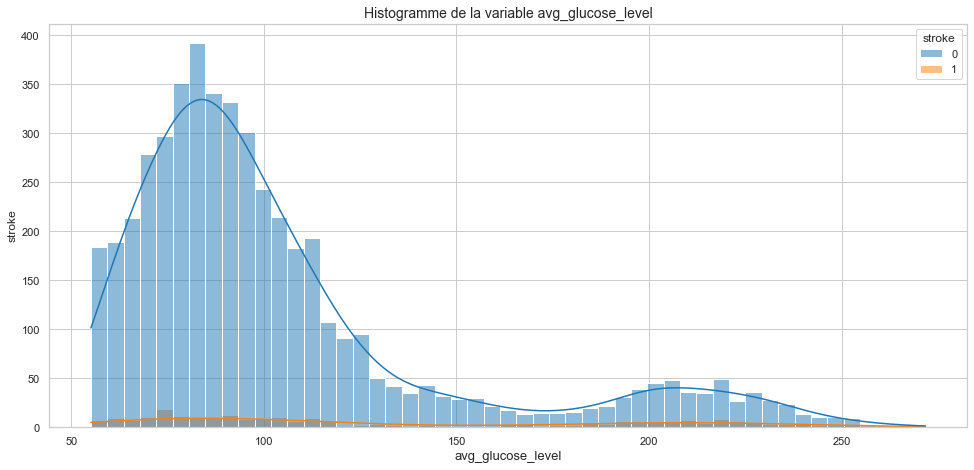

In [32]:
plt.figure(figsize = (15, 8))
sns.histplot(data = data_frame, x = "avg_glucose_level", hue = "stroke", kde = True, palette = "tab10")
plt.title(f"Histogramme de la variable avg_glucose_level", fontsize = 14)
plt.xlabel("avg_glucose_level", fontsize = 13)
plt.ylabel("stroke", fontsize = 12)
plt.tight_layout(pad = 5)

<p style="font-family:'Times New Roman'">Nous remarquons une différence entre les deux distributions qui ne semble pas très visible.</p>

<p style="font-family:'Times New Roman'"><strong>Pour la variable bmi</strong>. Nous pouvons remplacer les valeurs manquantes de la variable par la valeur la plus fréquente (mode).</p>

In [33]:
mode = data_frame["bmi"].mode()
data_to_plot = data_frame.fillna(mode)
plt.figure(figsize = (15, 8))
sns.histplot(data = data_to_plot, x = "bmi", hue = "stroke", kde = True, palette = "tab10")
plt.title(f"Histogramme de la variable bmi", fontsize = 14)
plt.xlabel("bmi", fontsize = 13)
plt.ylabel("stroke", fontsize = 12)
plt.tight_layout(pad = 5)

Error in callback <function flush_figures at 0x000002AF2BD68700> (for post_execute):


KeyboardInterrupt: 

Nous obtenons à peu près les mêmes distributions pour les deux classes de la cible.

## Relations entre variables non catégorielles

**Graphique de corrélations entre les variables quantitatives.**

<AxesSubplot:>

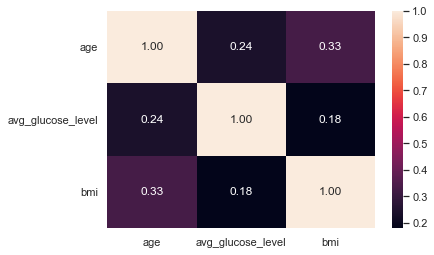

In [34]:
sns.heatmap(data_frame[non_categorical_columns].corr().round(2), annot = True, fmt = ".2f")

Nous remarquons qu'aucune des coefficients de corrélation obtenus ne dépasse 50%. Les variables quantitatives ne partagent aucune forte corrélation entre elles.

## Relations entre variables catégorielles et non catégorielles

Nous allons vérifier pour chaque variable quantitative si elle est influencée par une ou plusieurs variable(s) catégorielle(s).

In [35]:
def rel_cat_quant(categorical_column):
    """Fonction pour vérifier les relations pouvant exister entre les variables qualitatives
    et quantitatives. Nous allons utiliser la base de données ne comportant pas de valeurs 
    manquantes.
    
    Args:
        categorical_column(str): Nom de la variable catégorielle
    
    Returns:
        None
    """
    
    fig, axs = plt.subplots(2, 2, figsize = (18, 13))

    axs = axs.flat

    for i,column in enumerate(non_categorical_columns):

        sns.histplot(data = data_to_plot, x = column, kde = True, hue = categorical_column, ax = axs[i], palette = "tab10")

        axs[i].set_title(f"Variable {column}", fontsize = 14)

    fig.delaxes(axs[3])

    fig.tight_layout(pad = 3)

In [36]:
warnings.filterwarnings('ignore')

**Pour la variable hypertension**

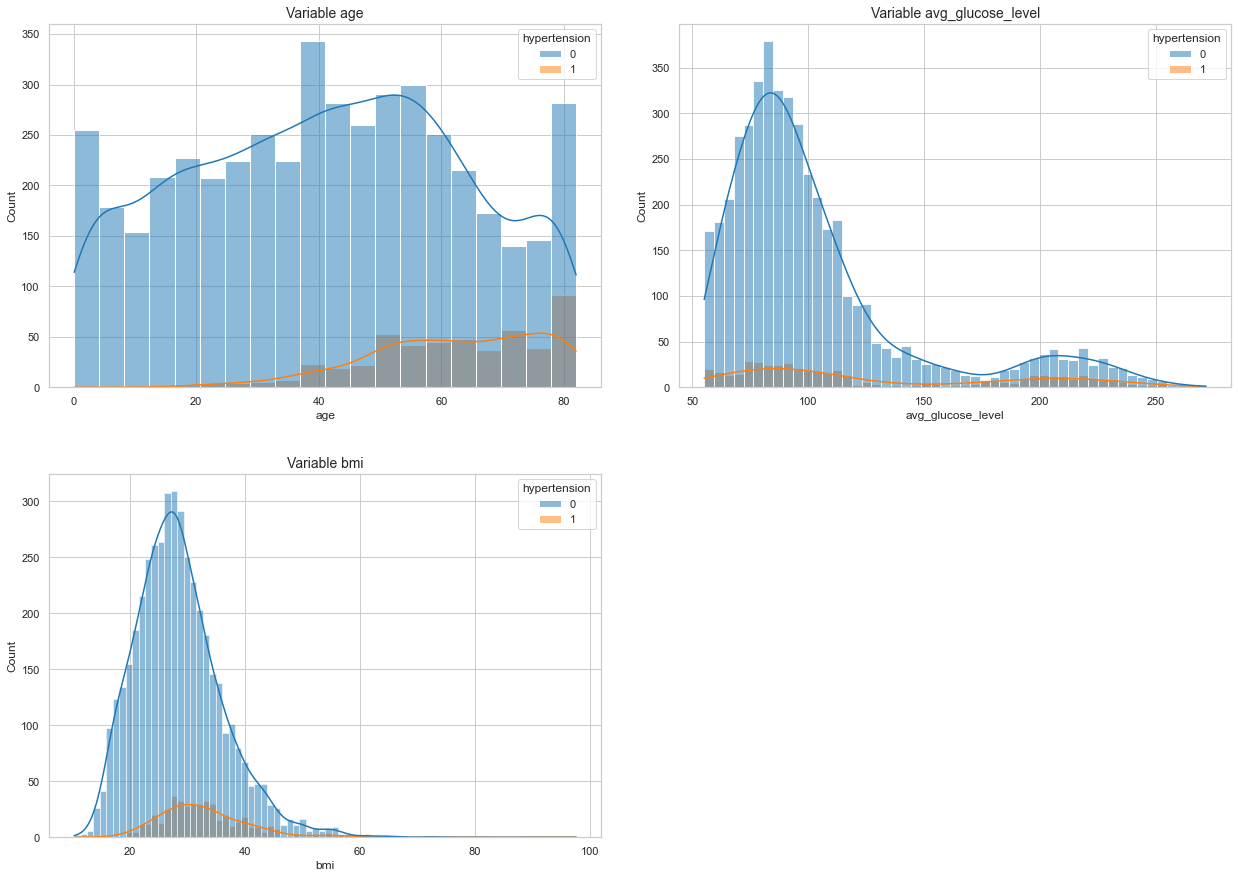

In [37]:
rel_cat_quant("hypertension")

Nous remarquons une **légère dépendance** entre les variables **hypertension** et **age**

**Pour la variable heart_disease**

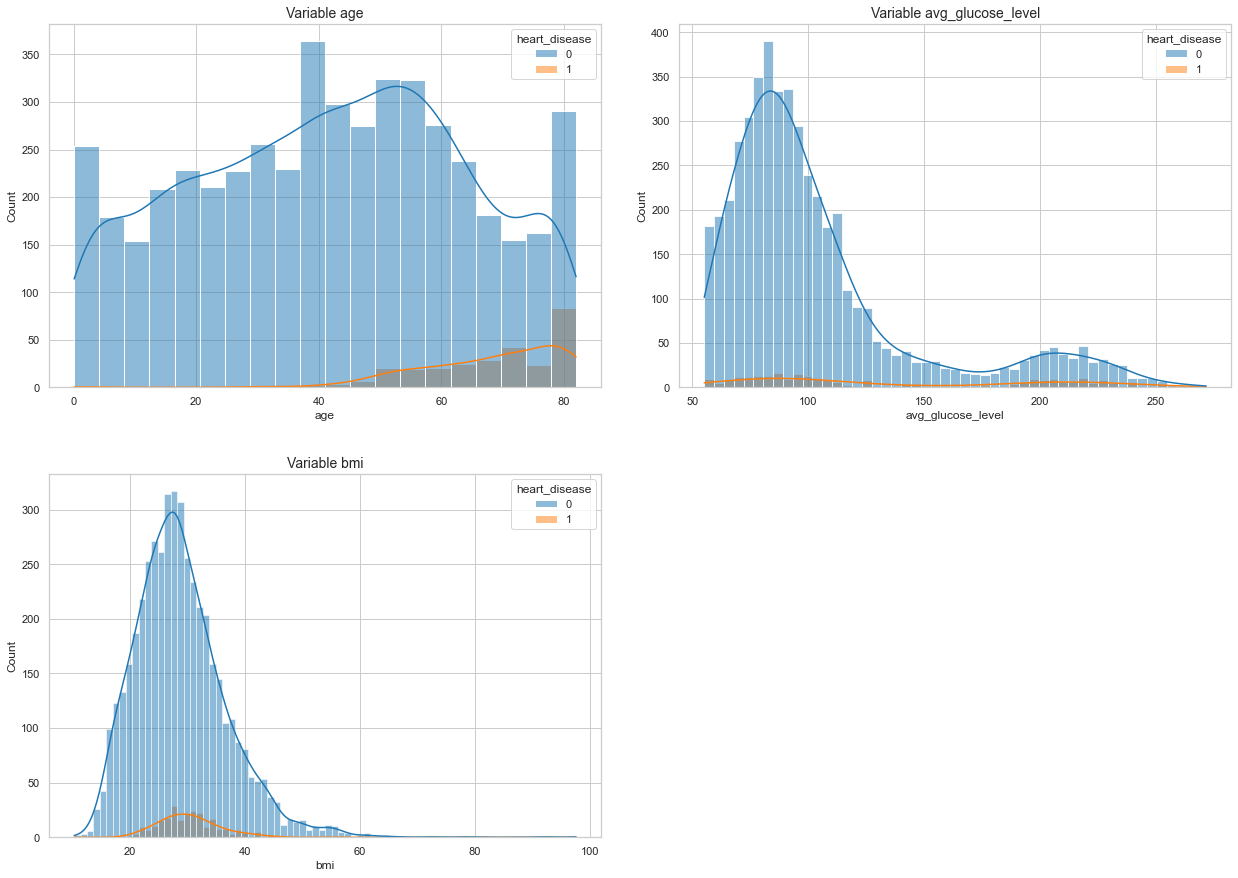

In [38]:
rel_cat_quant("heart_disease")

<p style="font-family:'Times New Roman'">Nous constatons également une <strong>légère dépendance</strong> entre les variables <strong>heart_disease</strong> et <strong>age</strong>.</p>

<p style="font-family:'Times New Roman'"><strong>Pour la variable gender</strong></p>

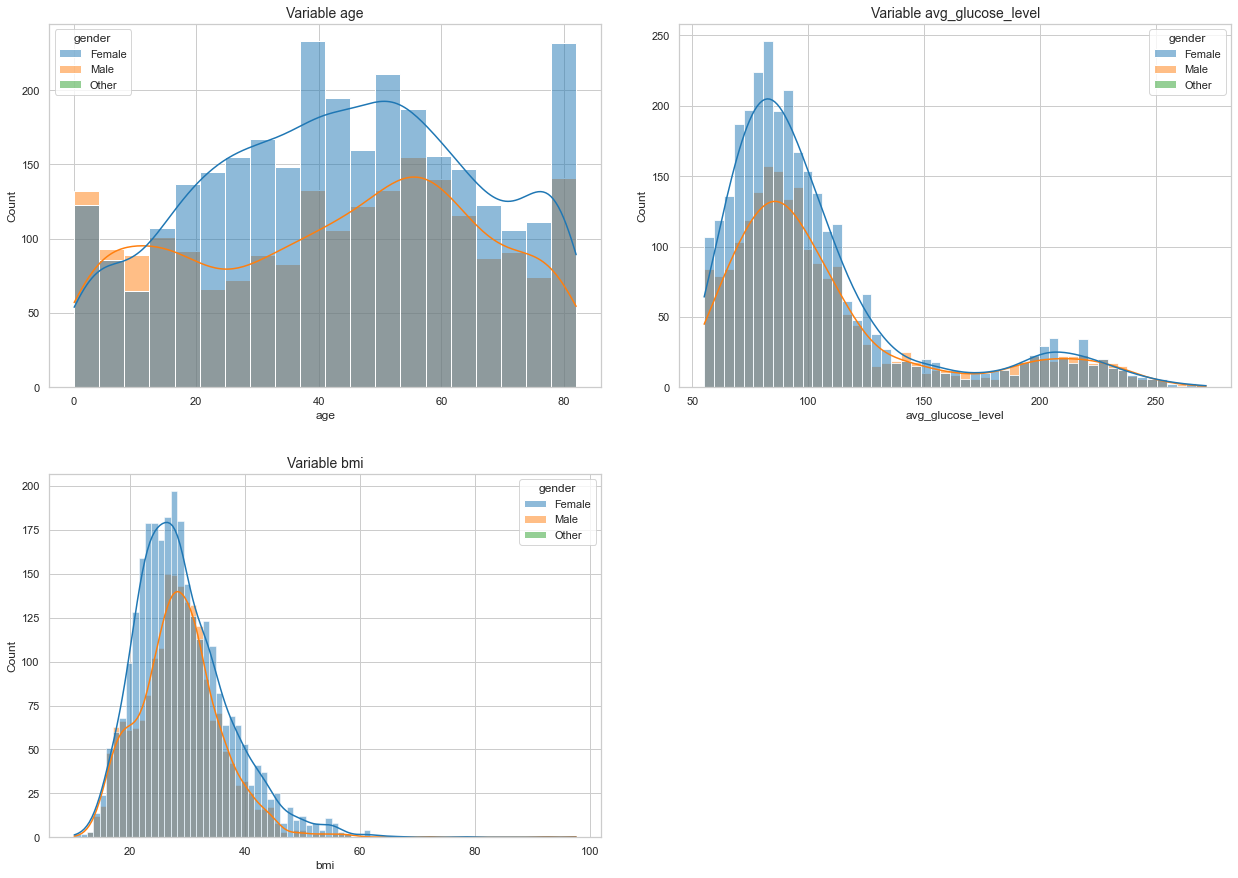

In [39]:
rel_cat_quant("gender")

Il n'existe **aucune forte corrélation** entre la variable **age** et **gender**

**Pour la variable ever_married**

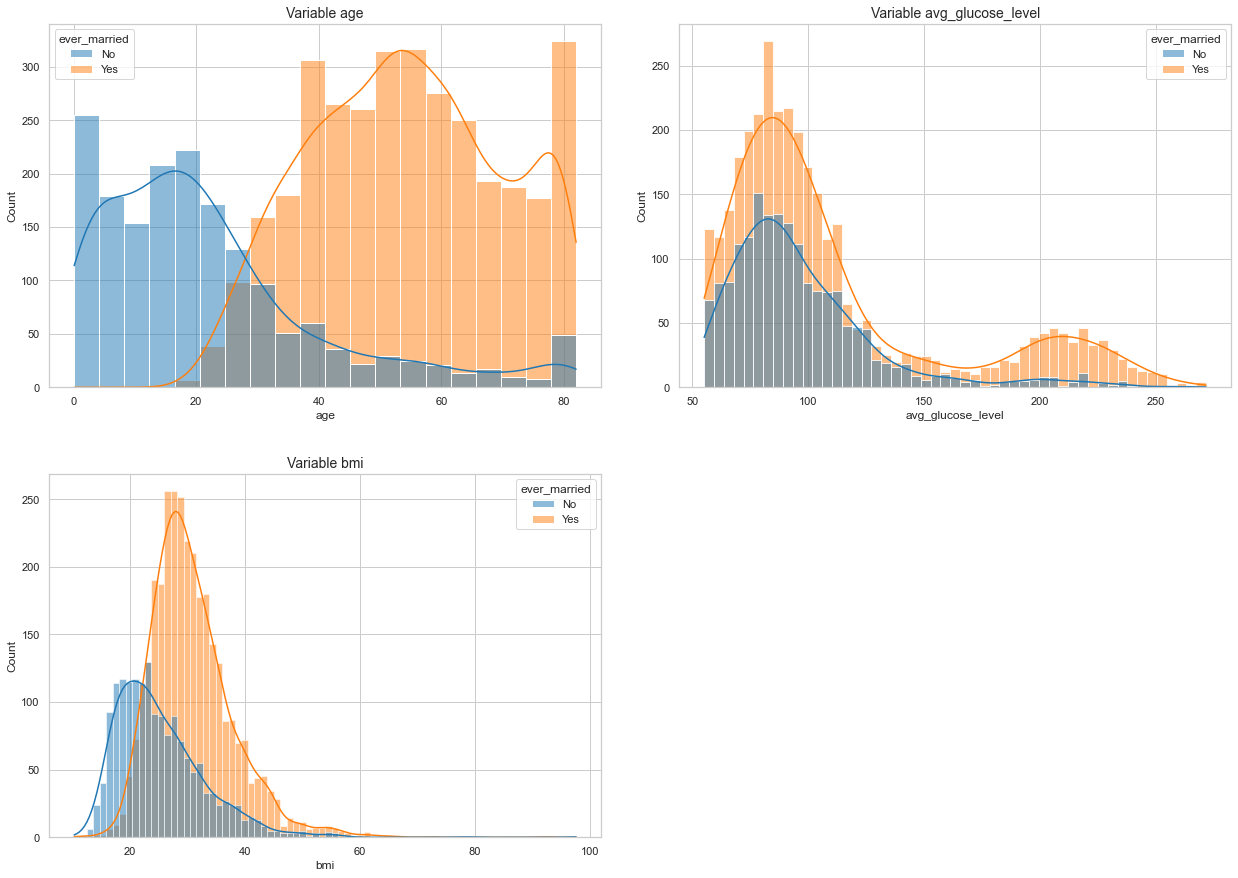

In [40]:
rel_cat_quant("ever_married")

La variable **ever_married** est **fortement corrélée** avec les variables **age** et **bmi**

**Pour la variable work_type**

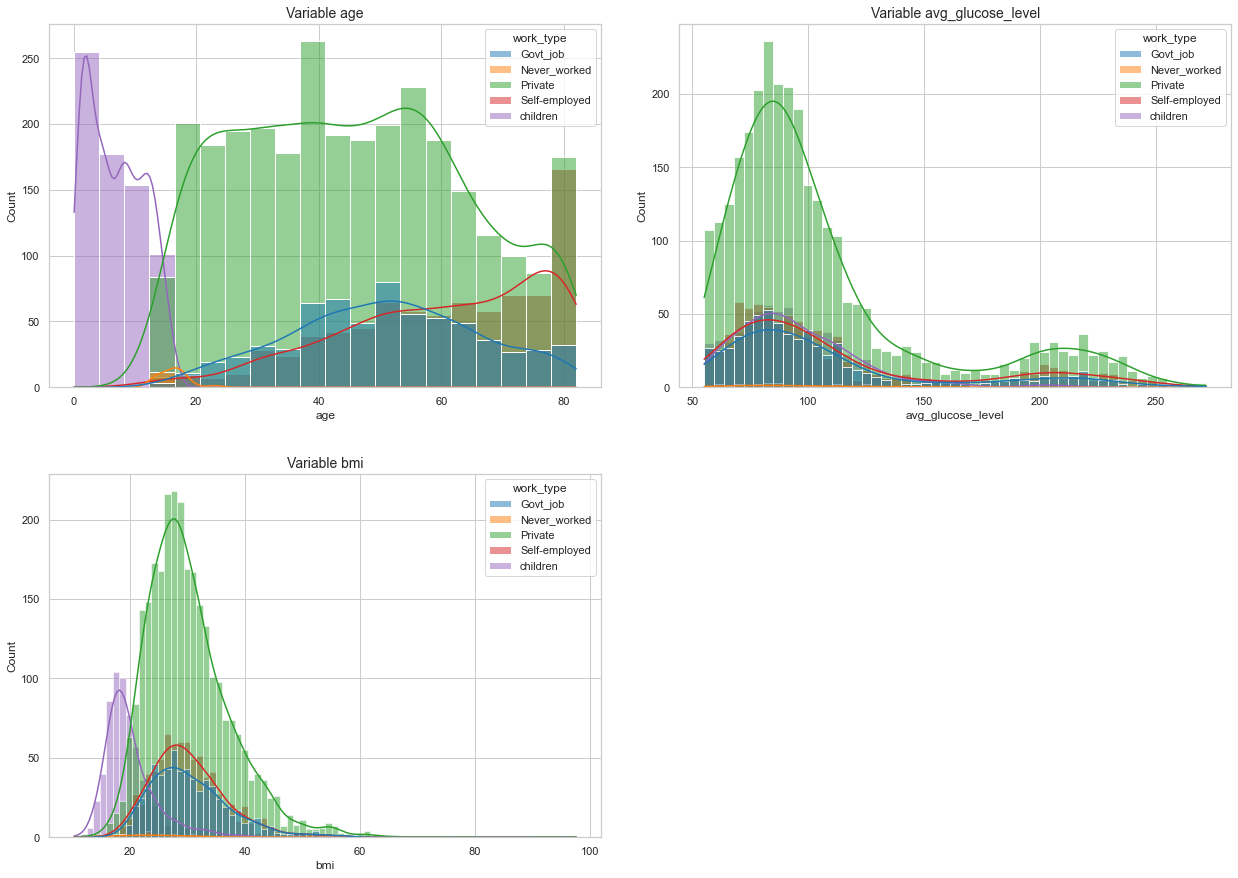

In [41]:
rel_cat_quant("work_type")

La variable **work_type** également réalise une **forte corrélation** entre les variables **age** et **bmi**. *Nous remarquons que la catégorie children de work_type désigne les patients enfants (donc la variable work_type est cohérente pour le reste de l'analyse)*.

<p style="font-family:'Times New Roman'"><strong>Pour la variable residence_type</strong></p>

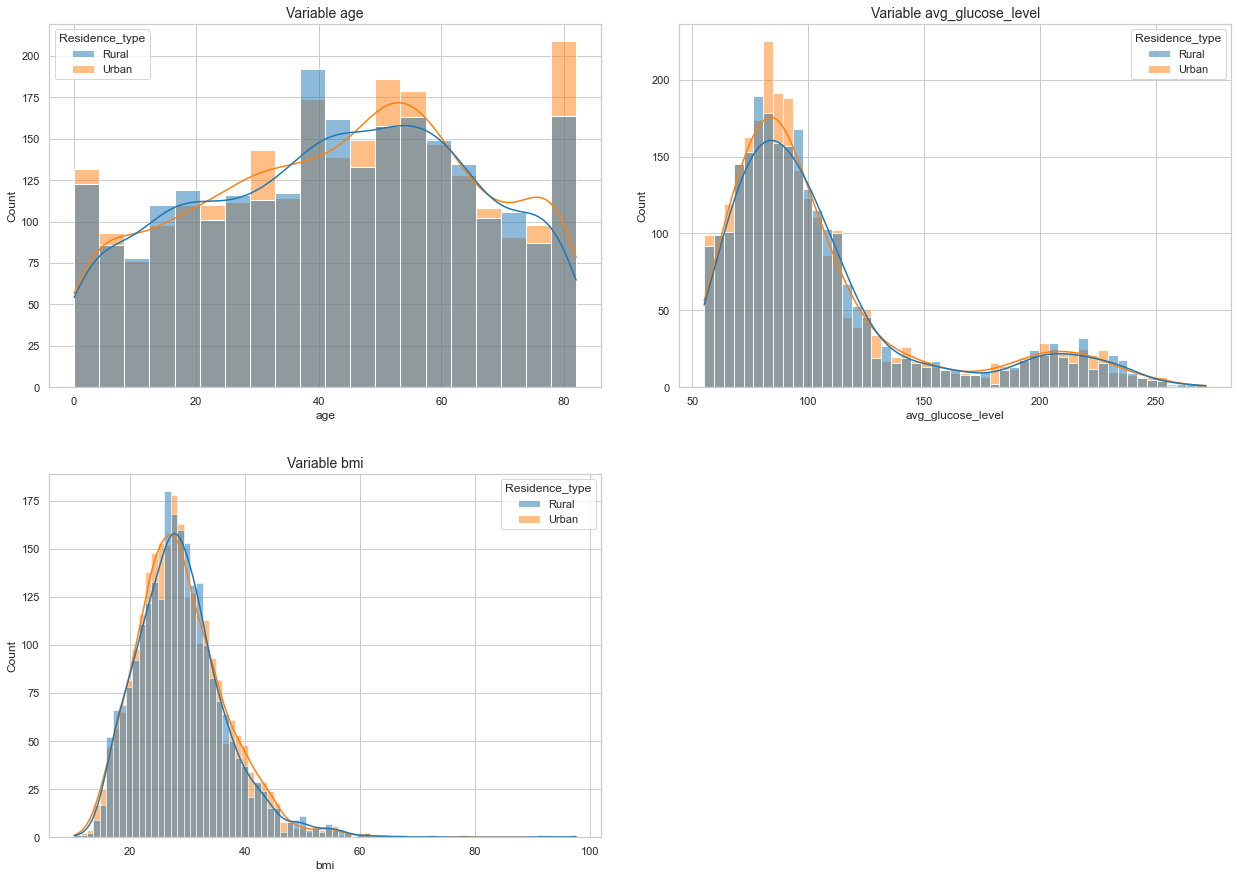

In [42]:
rel_cat_quant("Residence_type")

La variable **Residence_type** **n'est pas corrélée** avec la variable **age**.

**Pour la variable smoking_status**. Remplacons la catégorie *unknown* par *never smoked* pour avoir une meilleure représentation de la variable.

In [43]:
data_to_plot["smoking_status"] = data_to_plot["smoking_status"].apply(lambda x: "never smoked" if x == "Unknown" else x)

In [44]:
data_to_plot["smoking_status"].value_counts(normalize=True)*100

never smoked       67.240705
formerly smoked    17.318982
smokes             15.440313
Name: smoking_status, dtype: float64

In [45]:
rel_cat_quant("smoking_status")

Error in callback <function flush_figures at 0x000002AF2BD68700> (for post_execute):


KeyboardInterrupt: 

La variable **smoking_status** est **fortement corrélée** avec la variable **age**.

## Identification des valeurs aberrantes

**Diagrammes en moustache des variables catégorielles par classe de patients (atteints d'AVC ou pas).**

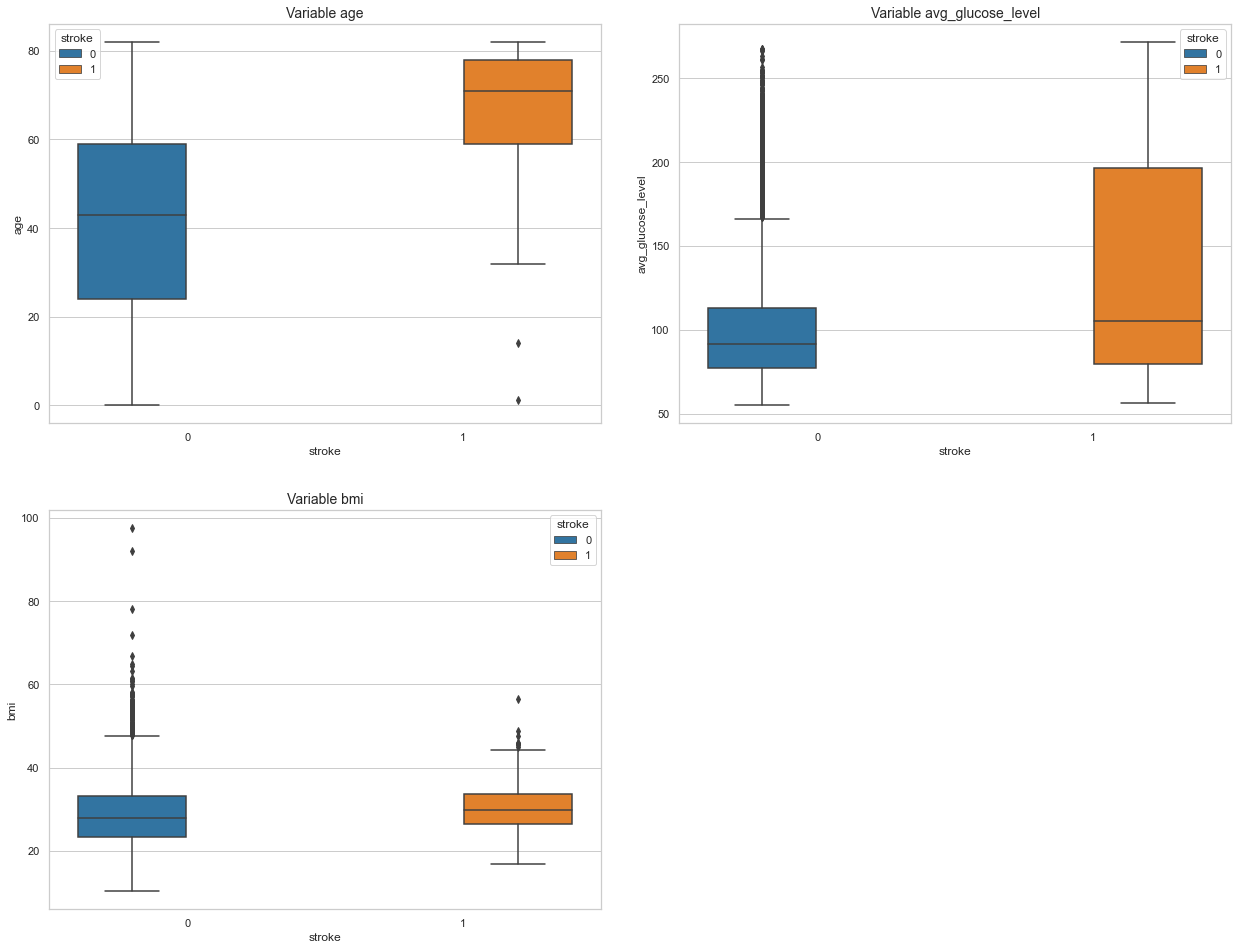

In [46]:
fig, axs = plt.subplots(2, 2, figsize = (18, 14))

axs = axs.flat

for i,column in enumerate(non_categorical_columns):

    sns.boxplot(data = data_to_plot, x = "stroke", y = column, hue = "stroke", ax = axs[i], palette = "tab10")

    axs[i].set_title(f"Variable {column}", fontsize = 14)

fig.delaxes(axs[3])

fig.tight_layout(pad = 3)

Nous constatons que tous les trois variables comportent des valeurs 'aberrantes'. Surtout du coté de la classe *test negatif* de la variable stroke (pour les variables bmi et avg_glucose_level).

## Test d'hypothéses

Vérifions si certaines variables quantitatives influencent le fait qu'un patient soit atteint d'AVC ou pas à l'aide d'un test de student (Hypothèse H0)

In [47]:
# Définition de la fonction pour effectuer des tests
def student_test(dataframe1: pd.DataFrame, dataframe2: pd.DataFrame, colonnes: list, alpha: float):
    """Cette fonction permet d'effectuer un test de student.
    
    Args:
        dataframe1(pandas.DataFrame): Les données de la première classe.
        dataframe2(pandas.DataFrame): Les données de la deuxième classe.
        colonne(list): Les noms des colonnes sur les quelles on va réaliser le test.
        alpha(float): Le taux d'erreur alpha de l'hypothèse nulle.
    
    Returns:
        None
    """
    
    # Choix d'un échantillon pour le dataframe qui a la plus grande taille
    if dataframe1.shape[0] <= dataframe2.shape[0]:
        dataframe2 = dataframe2.sample(dataframe1.shape[0])
    else:
        dataframe1 = dataframe1.sample(dataframe2.shape[0])
        
    for colonne in colonnes:
        stat, p = ttest_ind(dataframe1[colonne], dataframe2[colonne])
        if  p < alpha:
            print(f"{colonne:-<30} : H0 rejetée")
        else:
            print(f"{colonne:-<30} : H0 non rejetée")

In [48]:
df_positif, df_negatif = data_frame[data_frame["stroke"] == 1], data_frame[data_frame["stroke"] == 0]

**Nous obtenons les résultats suivants.**

In [49]:
# Effectuons le test
student_test(df_positif, df_negatif, non_categorical_columns, 0.02)

age--------------------------- : H0 rejetée
avg_glucose_level------------- : H0 rejetée
bmi--------------------------- : H0 non rejetée


Selon le test, seule la variable bmi n'entretient pas de relation avec la cible.

# Phase de Prétraitement des données

## Étapes du prétraitement

Nous allons effectuer plusieurs traitements sur les données et vérifier le score obtenu après entraînement d'un modèle d'arbre de décision (il ne s'agit pas du modèle final). Nous considérons que l'arbre de décision est le modèle de classification le plus facile à interpréter c'est pourquoi il est nécessaire de l'utiliser durant la phase de prétraitement.

- **Suppression de variables** : Nous diminuons considérablement le risque de surentraînement de nos modèles en supprimant les variables inutiles. Les variables fortement corrélées entre elles fournissent les mêmes informations au modèle. Ce surplus d'informations peut être corrigé avec la suppression de certaines variables qui sont fortement corrélées avec d'autres.
- **Suppression des données aberrantes** : Toutes les valeurs de la variable avg_glucose_level supérieures à environ 169 mg/dL, soit les valeurs désignant les patients qui ont un taux anormal de glucose dans le sang, sont supprimées. Nous obtenons ainsi une distribution à peu près normale pour la variable avg_glucose_level (La deuxième distribution est complètement supprimée). La distribution de la variable age reste à peu près la même. Après la suppression des valeurs aberrantes, la taille de l'échantillon est de **4483** observations. Cependant les variables considérées comme anormales peuvent être importantes lorsque nous aurons un nombre de malades plus grand dans la base de données (grâce au sur échantillonnage). Cela nous permettra notamment d'avoir un meilleur score pour la classe 1 qui était considérée comme un bruit à cause du fort déséquilibre de classes. Nous avions retenu en effet, au cours de la phase d'exploration, qu'un taux de glucose élevé dans le sang désigne les patients atteints de diabète.
- **Séparation des données** en données d'entraînement et de test : Les données d'entraînement vont contenir **3586** observations et les données de test, **897** observations.
- **Encodage des données qualitatives** : Il est important d'encoder les données de type *chaîne de caractères* avant de procéder à l'entraînement car les modèles qui seront utilisés sont incapables d'effectuer des calculs sur des données qualitatives sans une préalable transformation. 
- **Entraînement et évaluation du modèle de test** : En supprimant uniquement les variables bmi, work_type, ever_married, smoking_status et id on obtient une sensibilité de **96%** pour la classe *test negatif* et seulement **20%** pour la classe *test positif*.
- **Sélection de variables** : Les variables gender, hypertension, heart_disease et Residence_type sont celles qui doivent être supprimées. Ces variables sont les moins explicatives du lot de variables qui ont servi au précédent entraînement. Les variables age et avg_glucose_level sont à l'inverse les meilleures variables.
- **Entraînement et évaluation du modèle de test** avec les variables choisies : Nous obtenons une sensibilité de **96%** pour la classe *test négatif* et **29%** (soit une amélioration de 9%) pour la classe *test positif*.
- **Sur échantillonnage des données** : On choisit un pourcentage de 50% pour la stratégie de sur échantillonnage de la classe minoritaire. On améliore considérablement la sensibilité de la classe minoritaire ; mais cette stratégie diminuera en contrepartie la spécificité. En décidant de ne pas supprimer les valeurs 'anormales' de la variable avg_glucose_level, nous allons encore plus améliorer la sensibilité de la modalité *test positif* et, en contrepartie, diminuer la spécificité.
- **Entraînement et évaluation du modèle de test** après sur échantillonnage : Les distributions obtenus sont plus distinctives que celles d'avant. Par contre la distribution normale qu'on avait au niveau de la variable avg_glucose_level a été perdu. Cela risque de détériorer la spécificité mais en contrepartie on aura une meilleure sensibilité pour la modalité *test positif*. 
- **Conclusion** : Nous obtenons un bon score pour la classe *test négatif* mais pas pour la classe *test positif* qui reste très faible. Nous supposons que les données utilisées n'expliquent pas bien le phénomène *attraper un AVC*. Nous devons vérifier par la suite si on obtiendra de meilleures sensibilité et aire sous la courbe avec des modèles plus performants que l'arbre de décision. Grâce au sur-échantillonnage nous allons pouvoir éliminer les erreurs d'apprentissage qui seront commises par les modèles qui seront utilisés par la suite. On décide d'éliminer les valeurs aberrantes pour obtenir une meilleure aire sous la courbe que si l'on avait uniquement privilégier la sensibilité.
- **Recommandations** : Il est crucial de recueillir plus de données et d'augmenter le nombre de variables pertinentes nécessaires à l'analyse et à l'entraînement d'un modèle de détection d'AVC. La complétude dans la collecte n'a pas été totalement respectée. Une bonne stratégie de lutte contre l'AVC nécessite un supplément de variables très utiles à sa *prévention primaire*, telles que les suivantes :
    
    - **Le taux de cholestérol dans le sang** (en g/L) : Le cholestérol est un corps gras indispensable au fonctionnement de l’organisme. Il entre notamment dans la composition des membranes des cellules et sert, entre autres, de **' matière première '** à la synthèse de nombreuses hormones (stéroïdes). Cela étant, le cholestérol en excès peut être nuisible, car il a tendance à s’accumuler dans les vaisseaux sanguins et à former des plaques dites d’athérosclérose qui peuvent, à terme, augmenter le risque cardiovasculaire. L'analyse de cette variable nous permettrait par exemple de connaître le profil lipidique du patient (s'il est en état d'excès de cholestérol ou pas).
    
    - **La fibrillation auriculaire** : La fibrillation auriculaire (ou atriale) est un trouble du rythme cardiaque qui accélère le cœur et le fait battre de manière irrégulière. Son apparition est favorisée par le vieillissement et la présence d'une pathologie cardiaque (HTA, maladie des valves cardiaque...), d'une obésité, d'un syndrome d'apnée du sommeil obstructive etc.
    
    - **Consommation d'alcool du patient** : Cette variable pourrait avoir plusieurs valeurs possibles -
        - Le patient ne consomme pas d'alcool ;
        - Le patient consomme une certaine quantité par occasion (ex : cinq verres par occasion au moins une fois par semaine) ;
        - Le patient consomme quotidiennement de l'alcool.
        
     Cela nous permettra de savoir si le patient a une habitude de consommation qui dépasse les limites de ce qui est considéré comme une consommation “modérée” ou “socialement acceptable”. Cette variable peut aussi être exprimée en termes de quantités (litres) consommées par jour/semaine/mois/...
    - **La sédentarité** : elle correspond à une activité physique faible ou nulle avec une dépense énergétique proche de zéro ; la mesure du temps passé devant un écran que ce soit un ordinateur ou une télévision est un très bon indicateur de sédentarité.
    
    Il est possible de recueillir ces données à partir d'un site de consultation de dossiers médicales personnels de patients sur lesquels on a effectué des examens confirmant ou non la présence d'AVC. La consultation de ses sites peut nécessiter l'accord d'hôpitaux ou de clinique(s) en charges de ses dossiers médicaux. Un autre moyen d'acquérir ces données est d'effectuer une demande de consultation de dossiers personnels de patients, dans le but d'une enquête, à un professionnel de santé ou bien à l'accueil d'un établissement de santé (hôpitaux, cliniques...). Il peut nécessiter tout de même, à/aux enquêteur(s), d'acquérir un budget assez considérable pour effectuer cette enquête sauf si elle est financée par une association ou autres.   

In [50]:
class Traitement:
    """Cette classe va nous permettre d'effectuer des traitements sur les données.
    
    Attributes:
        dataframe(pandas.DataFrame): Les données avant tout traitement.
        cible(str): Le nom de la variable cible
    """
    
    def __init__(self, dataframe, cible):
        """Initialisation des attributs
        """
        if cible in dataframe.columns:
            self.dataframe = dataframe.copy()
            self.cible = cible
        else:
            raise ValueError("Le nom de la cible ne correspond à aucune colonne")
    
    def colonne_existe(self, colonne):
        """Fonction permettant de vérifier si une colonne existe.
        """
        return True if colonne in self.dataframe.columns else False
    
    def supprimer_colonnes(self, colonnes):
        """Cette fonction permet de supprimer des colonnes.
        """
        for colonne in colonnes:
            if self.colonne_existe(colonne):
                self.dataframe.drop(colonne, axis = 1, inplace = True)
            else:
                raise ValueError(f"La colonne {colonne} n'existe pas.")
    
    def modification_categorie(self, colonne, categorie_a_modif, categorie_de_modif):
        """Cette fonction permet de modifier une catégorie par une autre catégorie au sein
        d'une variable catégorielle.
        """
        modif = lambda x: categorie_de_modif if x == categorie_a_modif else x
        if self.colonne_existe(colonne):
            if self.dataframe[colonne].dtype == "category":
                self.dataframe[colonne] = self.dataframe[colonne].apply(modif)
                self.dataframe[colonne] = self.dataframe[colonne].astype('category')
            else:
                raise TypeError(f"La colonne {colonne} n'est pas une colonne catégorielle.")
        else:
            raise ValueError(f"La colonne {colonne} n'existe pas.")
    
    def supprimer_aberrantes(self, colonne):
        """Cette fonction permet de supprimer des données aberrantes
        """
        if self.colonne_existe(colonne):
            quantile_1 = self.dataframe[colonne].quantile(0.25)
            quantile_2 = self.dataframe[colonne].quantile(0.75)
            mediane = self.dataframe[colonne].median()
            inter_quantile = quantile_2 - quantile_1
            limite_bas = quantile_1 - 1.5 * inter_quantile
            limite_haut = quantile_2 + 1.5 * inter_quantile
#             remplacer_aberrante = lambda x : mediane if (x < limite_bas or x > limite_haut) else x
#             self.dataframe[colonne] = self.dataframe[colonne].apply(remplacer_aberrante)
            self.dataframe = self.dataframe[(self.dataframe[colonne] > limite_bas) & (self.dataframe[colonne] < limite_haut)]
        else:
            raise ValueError(f"La colonne {colonne} n'existe pas.")
    
    def separer_donnees(self, dataframe):
        """Cette fonction permet de séparer les données d'entraînement des données de test
        """
        y = dataframe[self.cible]
        
        X = dataframe.drop(self.cible, axis = 1)
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 4, shuffle = True)
        
        return X_train, X_test, y_train, y_test
    
    def encodage(self):
        """Cette fonction permet d'encoder les valeurs qualitatives
        """
        dataframe = self.dataframe.copy()
        for colonne in dataframe.select_dtypes("category").columns:
            dataframe[colonne] = self.dataframe[colonne].cat.codes
        return dataframe
    
    def sur_echantillonnage(self, X_train, y_train):
        """Cette fonction permet de créer de nouvelles instances à partir des observations actuelles
        """
        from collections import Counter
        from imblearn.pipeline import Pipeline
        from imblearn.under_sampling import RandomUnderSampler
        from imblearn.over_sampling import SMOTE
        warnings.simplefilter(action = "ignore", category = FutureWarning)
        
        print("Comptage des classes avant sur échantillonnage : \n{}".format(Counter(y_train)))
        sur_echant = SMOTE(sampling_strategy = 0.5, random_state = 0)
#         sous_echant = RandomUnderSampler(sampling_strategy = 0.7)
#         steps = [('o', sur_echant), ('u', sous_echant)]
#         pipeline = Pipeline(steps = steps)
        
#         X_train_s, y_train_s = pipeline.fit_resample(X_train, y_train)
        X_train_s, y_train_s = sur_echant.fit_resample(X_train, y_train)
        
        print("Comptage des classes après sur échantillonnage : \n{}".format(Counter(y_train_s)))
        
        return X_train_s, y_train_s
    
    def selection_variables(self, modele, X_train, y_train):
        """Cette fonction permet de sélectionner les variables qui apportent le plus d'information
        au modèle donné en paramètre.
        """
        from sklearn.feature_selection import SelectFromModel
        selector = SelectFromModel(modele)
        selector.fit(X_train, y_train)
        print(f"Colonnes choisies : \n", X_train.columns[selector.get_support()].tolist())
        return selector
    
    def premier_entrainement(self, X_train, y_train):
        """Cette fonction permet d'entraîner le premier modèle pour vérifier si le traitement effectué
        est bon.
        """
        from sklearn.tree import DecisionTreeClassifier
        
        modele = DecisionTreeClassifier(random_state = 4)
        
        modele.fit(X_train, y_train)
        
        return modele
    
    def evaluation(self, modele, nom_modele, X_train, X_test, y_train, y_test, plot_roc = False):
        """Cette fonction permet d'évaluer un modèle à l'aide de la matrice de confusion et 
        de la courbe ROC
        """
        from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
        from sklearn.model_selection import learning_curve
        import numpy as np
        
        y_pred = modele.predict(X_test)
        
        print(f"La precision du modèle : {accuracy_score(y_test, y_pred)}")
        print(f"Matrice de confusion : \n{confusion_matrix(y_test, y_pred)}")
        print(f"Rapport de classification : \n{classification_report(y_test, y_pred)}")
        
        N, train_score, test_score = learning_curve(modele, X_train, y_train, cv = 5, train_sizes = np.linspace(0.1, 1, 10))
        
        fig, axs = plt.subplots(1, 2, figsize = (17, 8))  
        
        axs[0].plot(N, train_score.mean(axis = 1), label = "score_entrainement")
        axs[0].plot(N, test_score.mean(axis = 1), label = "score_test")
        axs[0].set_title(f"Evaluation {nom_modele}")
        axs[0].set_xlabel(f"Tailles")
        axs[0].set_ylabel(f"Scores")
        axs[0].legend()
        
        plot_roc_curve(modele, X_test, y_test, ax = axs[1])
        axs[1].set_title(f"Courbe ROC {nom_modele}")
         
        fig.tight_layout(w_pad = 3)
        

In [51]:
# Création d'une instance de la classe Traitement 
traitement = Traitement(data_frame, "stroke")

## suppression de variables

Nous devons supprimer les colonnes bmi, work_type, ever_married, smoking_status et id.

In [52]:
traitement.supprimer_colonnes(['bmi', 'work_type', 'ever_married', 'smoking_status', 'id'])    

In [53]:
# Vérifions quelles sont les variables restantes 
print("Les variables restantes sont : " , ", ".join(traitement.dataframe.columns))

Les variables restantes sont :  gender, age, hypertension, heart_disease, Residence_type, avg_glucose_level, stroke


## Suppression des données aberrantes

Nous devons supprimer les valeurs aberrantes des variables age et avg_glucose_level.

In [54]:
traitement.supprimer_aberrantes("age")
traitement.supprimer_aberrantes("avg_glucose_level")

**Traçons les distributions des deux variables quantitatives pour vérifier les changements effectués.**

In [55]:
fig, axs = plt.subplots(1, 2, figsize = (17, 6))

axs = axs.flat

for i, colonne in enumerate(["age", "avg_glucose_level"]):
    fig.tight_layout(w_pad = 3, pad = 1.2)
    sns.histplot(data = traitement.dataframe, x = colonne, hue = "stroke", kde = True, ax = axs[i], palette = "tab10")
    axs[i].set_title(f"distribution de la colonne {colonne}")

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000002AF2BD68700> (for post_execute):


KeyboardInterrupt: 

In [ ]:
# Vérifions combien de données il nous reste
print("Sans valeurs aberrantes, il nous reste ", traitement.dataframe.shape[0], " observations dans le jeu de données.")

## Encodage des données qualitatives

Le nouveau jeu de données ne contiendra plus que des données quantitatives. *Cette étape n'est pas forcément utile car aucune des variables restantes n'est de type catégoriel*.

In [ ]:
new_data_frame = traitement.encodage()

## Séparation des données

In [ ]:
X_train, X_test, y_train, y_test = traitement.separer_donnees(new_data_frame)

<p style="font-family:'Times New Roman'">Vérifions les tailles des variables explicatives</p>

In [ ]:
# Verifions les tailles des variables explicatives
print("Taille des données d'entraînement : ", X_train.shape[0], " observations")
print("Taille des données de test : ", X_test.shape[0], " observations")

## Premier entraînement avec un arbre de décision

**Résultats du premier entraînement.**

In [ ]:
modele = traitement.premier_entrainement(X_train, y_train)

In [ ]:
sns.set_theme(style = "darkgrid")

In [ ]:
traitement.evaluation(modele, "Arbre de décision", X_train, X_test, y_train, y_test)

Nous obtenons une sensibilité égale à 20% (<50%) et une aire sous la courbe de 58% (proche de 50%). Nous constatons également un sur entraînement du modèle. Eliminons les variables non informatives détectées pendant la phase d'exploration, notamment avec le tableau de contingence, à l'aide de technique de sélection de variables.

## Sélection de variables

Vérifions quelles sont les variables qui apportent le plus d'information au modèle d'arbre de décision. 

In [ ]:
selector = traitement.selection_variables(tree.DecisionTreeClassifier(random_state = 4), X_train, y_train)

*Les variables qui n'apportent pas d'information au modèle sont les variables gender, hypertension, heart_disease et Residence_type qui vont être supprimées des données d'entraînement et de test.*

In [ ]:
# récupérations des noms des colonnes choisies
colonnes_choisies = X_train.columns[selector.get_support()]

In [ ]:
# suppression des colonnes inutiles
X_train, X_test = X_train[colonnes_choisies], X_test[colonnes_choisies]

## Deuxième entraînement du modèle avec les variables choisies

**Résultats du deuxième entraînement.**

In [ ]:
modele = traitement.premier_entrainement(X_train, y_train)
traitement.evaluation(modele, "Arbre de décision", X_train, X_test, y_train, y_test)

Nous notons une amélioration de la sensibilité de 9% ainsi que de l'aire sous la courbe qui passe à 62%. Nous notons toujours un sur entraînement du modèle mais moins grave que celui du premier entraînement. Par contre il est crucial d'augmenter la sensibilité. Pour cela nous pouvons utiliser des techniques de ré-échantillonnage. Le plus important est d'augmenter le nombre d'observations au niveau de la classe minoritaire. Le modèle pourra alors considérer la classe minoritaire comme une classe importante.

## Sur échantillonnage des données

In [ ]:
X_train_s, y_train_s = traitement.sur_echantillonnage(X_train, y_train)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (17, 6))

axs = axs.flat

for i, colonne in enumerate(["age", "avg_glucose_level"]):
    fig.tight_layout(w_pad = 3, pad = 1.2)
    sns.histplot(data = X_train_s, x = colonne, kde = True, ax = axs[i], palette = "tab10")
    axs[i].set_title(f"distribution de la colonne {colonne}")

Les distributions obtenus sont plus distinctives que celles d'avant. Par contre la distribution normale qu'on avait au niveau de la variable avg_glucose_level a été perdue. Cela risque de détériorer la spécifité mais en contrepartie on aura une meilleure sensibilité pour la modalité *test positif*.

## Troisième entraînement après sur échantillonnage

In [ ]:
modele_s = traitement.premier_entrainement(X_train_s, y_train_s)
traitement.evaluation(modele, "Arbre de décision", X_train_s, X_test, y_train_s, y_test)

Après le sur échantillonnage de la classe minoritaire, les scores obtenus avec l'arbre de décision ne change pas par rapport au dernier entraînement. Nous allons entraîner d'autres modèles plus performants que l'arbre de décision et vérifier si on obtient une amélioration des scores et une diminution du sur entraînement.

# Phase de modélisation

## Préambule

On devra entraîner un certain nombre de modèles et sélectionner celui qui donnera le meilleur score et qui ne sera ni trop complexe (score élevé sur les données d'entraînement et faible sur les données de test) et ni trop simple (score faible sur les données d'entraînement et de test). 
Le modèle final sera choisi parmi les suivantes : **RandomForestClassifier**, **AdaBoostClassifier**, **SVC**, **KNeighborsClassifier** et **LogisticRegression**.




L'entraînement d'un modèle nécessitera d'utiliser un pipeline (combinaison de traitements à effectuer) qui devra permettre **la discrétisation** des données quantitatives et **le sur échantillonnage** de la classe minoritaire avant **l'entraînement du modèle**. **L'évaluation du modèle** sera effectué immédiatement après son entraînement. *Pour la définition, discrétiser une variable quantitative c'est découper un vecteur de nombres réels en un vecteur de nombres entiers nommés "indices de classe" ou "codes de classe".*

In [ ]:
class SelectionModele(Traitement):
    """Cette classe permet d'effectuer plusieurs entraînement avec un certain nombre de modèles et hérite
    des méthodes de la classe Traitement
    Attributes:
        None    
    """
    
    def __init__(self):
        pass
    
    def multiple_entrainements(self, X_train, X_test, y_train, y_test, discretiser = True):
        """
        """
        from sklearn.compose import make_column_transformer, make_column_selector
        from imblearn.pipeline import make_pipeline
        from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, KBinsDiscretizer
        from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
        from sklearn.neighbors import KNeighborsClassifier
        from sklearn.linear_model import LogisticRegression
        from sklearn.svm import SVC
        from imblearn.over_sampling import SMOTE
        
        
        variables_numeriques = make_column_selector(dtype_include=np.number)
        
        pipeline_numerique = make_pipeline(KBinsDiscretizer(10, encode = "onehot")) if discretiser\
                             else make_pipeline(StandardScaler(), PolynomialFeatures())
        
        preprocesseur = make_column_transformer((pipeline_numerique, variables_numeriques))
        
        over_sample = SMOTE(sampling_strategy = 0.5, random_state = 0)
        
        Forest = make_pipeline(preprocesseur, over_sample, RandomForestClassifier(random_state = 4))
        Adaboost = make_pipeline(preprocesseur, over_sample, AdaBoostClassifier(random_state = 4))
        Svc = make_pipeline(preprocesseur, over_sample, SVC(random_state = 4))
        KNeighbors = make_pipeline(preprocesseur, over_sample, KNeighborsClassifier())
        Logistic = make_pipeline(preprocesseur, over_sample, LogisticRegression(random_state = 4))
        
        modeles_dict = {"Forêt aléatoire" : Forest,
                       "Adaboost" : Adaboost,
                       "SVC" : Svc,
                       "KNN" : KNeighbors,
                       "Logistic" : Logistic
                      }
        
        for nom, modele in modeles_dict.items():
            print(f"{'-'*15}\nPour le modèle {nom} :")
            modele.fit(X_train, y_train)
            self.evaluation(modele, nom, X_train, X_test, y_train, y_test, True)
            yield nom, modele
        
    def courbe_sensibilite_precision(self, modele, X_test, y_test):
        """Une fonction qui permet de tracer la courbe de Precision-Recall pour le choix d'un seuil.
        Args:
            modele (pipeline): Le modèle choisi
            X_test (pandas.DataFrame): Les caractéristiques de test
            y_test (pandas.DataFrame): Les données test de la cible
        
        Returns:
            None
        """
        from sklearn.metrics import precision_recall_curve
        
        precision, sensibilite, seuil = precision_recall_curve(y_test, modele.decision_function(X_test))
        
        plt.plot(seuil, precision[:-1], label = 'precision')
        plt.plot(seuil, sensibilite[:-1], label = 'sensibilité')
        plt.legend()

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
# instenciation de la classe
selection_modele = SelectionModele()

## Sélection de modèle

In [ ]:
# initialisation du générateur
generateur_modeles = selection_modele.multiple_entrainements(X_train, X_test, y_train, y_test, False)

### Random Forest

In [ ]:
nom, modele = next(generateur_modeles)

Nous notons un sur entraînement du modèle. Nous obtenons une sensibilité de 31% et une aire sous la courbe de 78% soit, déjà, une grande amélioration par rapport au modèle de test.

### Adaboost

In [ ]:
nom, modele = next(generateur_modeles)

Ce modèle est plus performant que le précédent. On note une diminution du sur apprentissage et une amélioration de la sensibilité. 

### SVC

In [ ]:
nom, modele = next(generateur_modeles)

Ce modèle n'est quasiment pas sur entraîné et on obtient de meilleurs scores que pour les précédents modèles avec une AUC de 84% et une sensibilité de 60%.

### KNN

In [ ]:
nom, modele = next(generateur_modeles)

La performance du modèle KNN est située entre celle du forêt aléatoire et de l'Adaboost. Le modèle est sur entraîné et on obtient une sensibilité de 43% et une aire sous la courbe de 74%.

### LOGISTIC

In [ ]:
nom, modele = next(generateur_modeles)

Le meilleur modèle est la **régression logistique** avec une aire sous la courbe de **83%** et une sensibilité de **60%**. Bien que l'aire sous la courbe soit d'une unité inférieure à celle du modèle SVC on remarque que les scores obtenus pour les données d'entraînement et de test sont plus proches et montrent une meilleure harmonie.

## Description du modèle choisi

### C'est quoi la régression logistique ?

<div align="justify" style = "font-family:'Times New Roman'">
<p>La régression logistique est une méthode qui permet de modéliser des variables binomiales (typiquement binaires), multinomiales (variables qualitatives à plus de deux modalités) ou ordinales (variables qualitatives dont les modalités sont ordonnées). Elle est très utilisée dans le domaine médical (guérison ou non d'un patient), en sociologie, en épidémiologie, en marketing quantitatif (achat ou non de produits ou services suite à une action) et en finance pour la modélisation de risques (scoring).</p>
<p>Le principe du modèle de la régression logistique est d'expliquer la survenance ou non d'un événement (la variable cible que nous noterons y) par le niveau de variables explicatives (notées X). Dans notre exemple, on cherche à prédire la sortie de la variable y (patient atteint d'AVC ou pas) en fonction des données relevées sur les patients.</p>
</div>

### Comment fonctionne la régression logistique ?

La régression logistique et la régression linéaire appartiennent à la même famille des modèles GLM **Generalized Linear Models**) : dans les deux cas, on relie un événement à une combinaison linéaire de variables explicatives.

Dans le cas de la régression linéaire ordinaire, la variable dédendante Y suit une loi normale $N(\mu, \sigma)$ où $\mu$ est une fonction linéaire des variables explicatives. Pour la régression logistique binomiale, la variable dépendante, aussi appelée variable réponse, suit une loi de Bernoulli de paramètre p (p étant la probabilité pour que l'événement se produise), lorsque l'expérience est répétée une fois, ou une loi Binomiale(n, p) si l'expérience est répétée n fois (par exemple la même dose est essayée sur n patients). Dans le cas de la régression logistique, le paramètre de probabilité p est une fonction combinaison linéaire des variables explicatives X.

Le cas **binaire** est le cas où la variable réponse peut prendre 2 valeurs (correspondant à un tirage de Bernoulli), et le cas **somme de binaires** le cas où la variable réponse est le comptage du nombre de fois où l'événement d'intérêt s'est produit.

Les fonctions les plus couramment utilisées pour relier la probabilité p aux variables explicatives sont la fonction logistique (on parle alors de modèles **Logit**) et la fonction de répartition de la loi normale standard (on parle alors de modèle **Probit**). Ces deux fonctions sont parfaitement symétriques et sigmoïdes (La courbe en S représentée par la fonction $f_\lambda(x) = f(\lambda x) = \frac{1}{1+e^{-\lambda x}}$). La fonction sigmoide à la particularité d'être toujours comprise entre 0 et 1. Ainsi pour un seuil fixé entre 0 et 1 (la plupart du temps un seuil de 0.5) si le résultat de la fonction sigmoide, suivant les valeurs en entrées, est supérieur ou égale au seuil, alors on considère que l'individu est de classe 1 et sinon on considère qu'il est de classe 0. Dans le cas du dépistage de cancer du poumon on considérera ainsi que si les données d'un patient conduisent à la classe 1 alors il atteint de cancer et sinon il n'est pas atteint. A chaque résultat on attribue une probabilité qui indique son taux de certitude.


### Les paramètres du modèle

<p style="font-family:'Times New Roman'">Affichage des paramètres du modèle.</p>

In [ ]:
modele.get_params()

- **penalty (pénalité)** : Ce paramètre est utilisé pour spécifier la norme (L1 ou L2) utilisée dans la pénalisation (régularisation). Il peut prendre les valeurs : 'L1', 'L2', 'elasticnet' ou none (aucun).
- **dual (double)** : Il est utilisé pour la formulation double ou primale. La formulation double n’est mise en œuvre que pour la pénalité L2. Il prend des valeurs booléennes. 
- **tol (tolérance)** : Il représente la tolérance pour les critères d’arrêt.
- **C** : Il représente l’inverse de la force de régularisation. Il doit toujours être une décimale positive.
- **fit_intercept** : Ce paramètre spécifie si une constante (biais ou interception) doit être ajoutée à la fonction de décision. Il prend des valeurs booléennes.
- **intercept_scaling** : Ce paramètre est utile lorsque le solveur 'liblinear' est utilisé ou que 'fit_intercept' est défini sur vraie. Il prend des valeurs décimales.
- **class_weight** : Il représente les poids associés aux classes. Si nous utilisons l’option par défaut ('none' qui veut dire aucun), cela signifie que toutes les classes sont censées avoir un poids égal à 1. D’autre part, si vous choisissez la valeur 'équilibré', il utilisera les valeurs de y pour ajuster automatiquement les poids.
- **random_state** : Ce paramètre représente la graine du nombre pseudo aléatoire généré qui est utilisé lors du brassage des données. Voici les options -

    - **int (entier)** : dans ce cas, random_state est la graine utilisée par le générateur de nombres aléatoires.
    - **'Instance RandomState'** : dans ce cas, random_state est le générateur de nombres aléatoires.
    - **Aucun** : dans ce cas, le générateur de nombres aléatoires est l’instance RandonState utilisée par np.random.


- **solver (solveur)** : Ce paramètre représente l’algorithme à utiliser dans le problème d’optimisation. Voici les propriétés des options sous ce paramètre -

    - **liblinear** : C’est un bon choix pour les petits ensembles de données. Il gère également la pénalité L1. Pour les problèmes multi classes, il est limité aux schémas à un contre repos.
    - **newton-cg** : Il ne gère que la pénalité L2.
    - **lbfgs** : Pour les problèmes multi classes, il gère la perte multinomiale. Il ne gère également que la pénalité L2.
    - **saga** : C’est un bon choix pour les grands ensembles de données. Pour les problèmes multiclasses, il gère également la perte multinomiale. En plus de la pénalité L1, il prend également en charge la pénalité « elasticnet ».
    - **sag** : Il est également utilisé pour les grands ensembles de données. Pour les problèmes multi classes, il gère également la perte multinomiale.


- **max_iter** : Comme son nom l’indique, il représente le nombre maximal d’itérations prises pour que les solveurs convergent.
- **multi_class** :

    - **ovr** : Pour cette option, un problème binaire convient à chaque étiquette.
    - **multimonial** : Pour cette option, la perte minimisée est l’ajustement de la perte multinomiale sur l’ensemble de la distribution de probabilité. Nous ne pouvons pas utiliser cette option si solver = 'liblinear'.
    - **auto** : Cette option sélectionnera 'ovr' si solver = 'liblinear' ou si les données sont binaires, sinon il choisira 'multinomial'.


- **verbose** : Par défaut, la valeur de ce paramètre est 0, mais pour le solveur liblinear et lbfgs, nous devons définir verbose sur n’importe quel nombre positif.
- **warm_start** : Avec ce paramètre défini sur True, nous pouvons réutiliser la solution de l’appel précédent pour l’adapter en tant qu’initialisation. Si nous choisissons la valeur par défaut, c’est-à-dire faux, cela effacera la solution précédente.
- **n_jobs** : Si multi_class = 'ovr', ce paramètre représente le nombre de cœurs de CPU utilisés lors de la parallélisation sur les classes. Il est ignoré lorsque solver = 'liblinear'.
- **l1_ratio** : Il est utilisé dans le cas où penalty = 'elasticnet'. Il s’agit essentiellement du paramètre de mélange Elastic-Net avec 0 < = l1_ratio > = 1.

**Définition des principaux termes**:

- Régularisation : À la base, la régularisation tente de limiter le surapprentissage. La régularisation peut s’introduire dans la fonction de coût (fonction de perte ou d'erreurs que l'on doit minimiser). Les normes L1 ou L2 sont des termes ajouté à la fonction de coût en tant que terme de régularisation. L’ajout de tels termes de régularisation à la fonction de coût est un concept très populaire en apprentissage machine. $\theta_i$ représente l'estimation (ou valeur prédite) d'un paramètre du modèle.

- Norme *L1* : $\lambda\sum_{i=1}^n|\theta_i|$. 
La régularisation par norme L1 (Lasso) tente de minimiser la somme des différences absolues entre valeurs réelles et valeurs prédites. Linéaire, elle offre la possibilité au modèle de facilement fixer un poids à 0 et peut donc, entre autres, faciliter la sélection de caractéristiques en forçant une représentation éparse. 

- Norme *L2* : $\lambda\sum_{i=1}^n\theta_i^2$. 
La régularisation par norme L2 (Ridge / Tikhonov) tente de minimiser la somme des carrées des différences entre valeurs réelles et valeurs prédites. Ce terme est, entre autres, plus rapide à calculer que le terme L1. Exponentielle, elle promouvoit plutôt une représentation diffuse et, de ce fait, performe généralement mieux que la L1.

- Poids de régularisation (hyperparamètre) : l’ampleur de l’effet du terme de régularisation est contrôlé grâce à un poids $\lambda$ placé à l’avant du terme.

## Optimisation de la performance du modèle

In [ ]:
cv = RepeatedStratifiedKFold(n_repeats = 10, random_state = 0)

Optimisons la performance du modèle avec une validation croisée stratifiée et la recherche par grilles aléatoires. L'un nous permettra d'effectuer des validations croisées en sélectionnant les ensembles par strates (par rapport à chaque modalité) et l'autre utilisera le premier pour vérifier la combinaison des paramètres du modèle qui donnent le meilleur score. On prendra comme métrique la sensibilité pour la recherche des meilleurs paramètres du modèle. 


*Il est important de noter que la recherche par grille ne sera pas effectuée sur toutes les valeurs des paramètres mais se fera plutôt par sélections aléatoires.*
    

**Conclusion** : Nous avons choisi un nombre de valeurs très important pour chaque paramètre en tenant compte des disparités existantes entre elles. Nous évaluons le temps d'exécution de l'algorithme (de la recherche par grilles jusqu'à l'évaluation du meilleur modèle) entre 1 et 2 minutes sur le support utilisé pour les tests. Cependant sur des appareils beaucoup moins adaptés à ce genre de calculs nous pouvons noter un temps d'exécution pouvant excéder les 2 minutes.



In [ ]:
params = {
#     "columntransformer__pipeline__kbinsdiscretizer__n_bins" : np.arange(3, 25),
    "columntransformer__pipeline__polynomialfeatures__degree" : np.arange(2, 20),
    "smote__k_neighbors" : np.arange(3, 14),
    "smote__sampling_strategy" : np.linspace(0.1, 1, 10),
    "logisticregression__C": np.linspace(0.1, 10, 100),
    "logisticregression__dual": [True, False],
    "logisticregression__fit_intercept": [True, False],
    "logisticregression__penalty": ['l1', 'l2', 'elasticnet', 'none'],
    "logisticregression__solver": ["lbfgs", "saga"]
}

**Les meilleurs paramètres choisis avec une graine égale à 19.**

In [ ]:
grid = RandomizedSearchCV(modele, params, n_iter = 15, scoring = "recall", cv = cv, random_state = 19)
grid.fit(X_train, y_train)
grid.best_params_

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
modele = grid.best_estimator_

**Résultats obtenus avec le meilleur modèle.**

In [ ]:
selection_modele.evaluation(modele, "Logistic", X_train, X_test, y_train, y_test)

Avec les paramètres optimaux choisis aléatoirement nous obtenons une sensibilité de **89%** (> 80%) et une aire sous la courbe de **84%** (>80%) et nous n'avons quasiment plus de sur entraînement observable. Donc nous pouvons dire que nous avons atteint l'objectif fixé.

## Compromis entre Sensibilité et Précision

<p style="font-family:'Times New Roman'">Tracons la courbe de Sensibilité-Précision pour vérifier quel seuil nous permet d'obtenir une bonne sensibilité sans pour autant trop diminuer la précision.</p>

In [ ]:
selection_modele.courbe_sensibilite_precision(modele, X_test, y_test)

**Calcul de la sensibilité**

Nous obtenons ainsi une sensibilité finale de **94%** pour un seuil de -0.001

## Conclusion

- La phase d'exploration des données nous a permis de détecter des anomalies, notamment les éléments suivants :
    
    - Déséquilibre de classes (variable stroke) ;
    - Valeurs manquantes dans la variable bmi ;
    - Valeurs aberrantes dans les variables quantitatives ;
    - Valeurs inconsistantes dans la variable smoking_type ;
    - Corrélations entre variables ;
    - Variables inutiles dans l'analyse (variable id) ;
    - Variable n'apportant pas d'informations.
    
- A travers une démarche **évaluation -> idée -> code**, on a déterminé comment traiter idéalement les données pour obtenir une amélioration du modèle de test (l'arbre de décision). On obtient un plus bon score sur le modèle de test en effectuant les prétraitements suivant :

    - Suppression de variables jugées inutiles ou fortement corrélées avec la variable age ou avg_glucose_level ;
    - Suppression de valeurs aberrantes pour obtenir une meilleure *auc* ;
    - Séparation des données en données d'entraînement et de test ;
    - Sélection de variables après première évaluation ;
    - Sur échantillonnage des données après deuxième évaluation.
    
- Entraînement de plusieurs modèles (avec des données quantitatives discrétisées et sur échantillonnage de la classe minoritaire) et choix du meilleur modèle qui est la régression logistique ;

- Optimisation du modèle choisi en choisissant les paramètres lui fournissant le meilleur score (meilleure sensibilité et meilleure auc) ;

- On obtient une sensibilité de 89% et une sensibilité de 84% après la recherche par grille ;

- On essaie de trouver un seuil optimal pour la sensibilité (pour un seuil de -0.001 on obtient une sensibilité de 94%).


## Procédure de déploiement du modèle

Le déploiement du modèle va nécessiter la librairie joblib qui va nous permettre de sauvegarder le modèle et la conception d'un package et d'un environnement virtuel à l'aide de la librairie poetry afin d'exécuter des tests et des prédictions après chargement du modèle retenu. 
La méthode argparse permet d'envoyer directement les valeurs des variables age et taux de glucose sous forme de paramètres à un fichier predict.py qui va donner directement le résultat souhaité. Cependant étant donné le manque de complétude dans la collecte de données il est plus judicieux de ne pas utiliser ce modèle pour la détection d'AVC (*consulter un médecin serait plus judicieux pour le moment*).